# Project Milestone P4: Creative Extension

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [207]:
!if [ ! -d img ]; then mkdir img; fi

## Data Wrangling
### Loading Datasets

* `paper_dataset`: full dataset from paper, with all variables loaded
* `ucdp_prio_data`: raw UCDP Prio dataset with conflict ID and location
* `paper_data_countries` : dataset which links `cowcode`, `cid`, `id` and `country`. 
* `paper_data_merged`: full dataset from paper, with countries specified (merged on `cid` and `year`)
* `ged_201`: dataset after 1989 with conflict id and geographical location (used for conflicts of type 2)
* `ucdp_wrangled`: UCDP data with geographical location for all conflict types
* `joined`: `ucdp_wrangled` joined with paper data, with binary `war` variable
* `wiid_gini_raw`: WIID inequality dataset, raw
* `ineq_gini`: country, year, gini data from WID
* `df_gini_clean`: final dataset with Gini score
* `df_no_gini_clean`: final dataset without Gini score

In [2]:
# Global configuration for running
CFG = {
    "plot_heatmaps" : False,
    "cross_val" : False,
    "matching" : True,
    "nowarns" : True
}

In [3]:
DATA_FOLDER = "data/"
ORIGINAL_PAPER_DATA = DATA_FOLDER + "SambnisImp.csv"
ORIGINAL_PAPER_COUNTRY = DATA_FOLDER + "sambanis_countries.dta"
UCDP_PRIO_DATA = DATA_FOLDER + "ucdp-prio-acd-201-csv.zip"
#UCDP_ACTOR_DATA = DATA_FOLDER + "ucdp-actor-201.xlsx"
WID_DATA_FOLDER = DATA_FOLDER + "wid_all_data/"
GED_201 = DATA_FOLDER + "ged201-csv.zip"

**Dataset from Muchlinski et al. paper**

In [4]:
paper_dataset = pd.read_csv(ORIGINAL_PAPER_DATA)
paper_dataset.head()

Unnamed: 0  atwards  X   id  cid  cowcode  year  warstds  ptime  yrint  \
0           1        0  1  1.0    1      700  1945        0     12      0   
1           2        0  2  1.0    1      700  1946        0     24      1   
2           3        0  3  1.0    1      700  1947        0     36      2   
3           4        0  4  1.0    1      700  1948        0     48      3   
4           5        0  5  1.0    1      700  1949        0     60      4   

   ...  decade1  decade2  decade3  decade4  independ   tip  anocracy  \
0  ...        0        0        0        0         1  17.0         0   
1  ...        0        0        0        0         1  18.0         0   
2  ...        0        0        0        0         1  19.0         0   
3  ...        0        0        0        0         1  20.0         0   
4  ...        0        0        0        0         1  21.0         0   

   proxregc  sxpnew.2   sxpsq.2  
0  0.143299  0.094095  0.094095  
1  1.000000  0.094547  0.094547  
2  1.000000  0.095567  0.095567  
3  1.000000  0.101303  0.101303  
4  1.000000  0.092107  0.092107  

[5 rows x 286 columns]

**UDCP Dataset**

In [5]:
#ucdp_actor_data = pd.read_excel(UCDP_ACTOR_DATA, sheet_name='Dataset')
#ucdp_actor_data.head()

In [6]:
ucdp_prio_cols = ['conflict_id', 'year', 'intensity_level', 
                  'cumulative_intensity', 'type_of_conflict', 'location',
                 'territory_name']
ucdp_prio_data = pd.read_csv(UCDP_PRIO_DATA, usecols=ucdp_prio_cols)
ucdp_prio_data.head()

conflict_id       location territory_name  year  intensity_level  \
0        11342          India       Garoland  2012                1   
1        11342          India       Garoland  2014                1   
2        11343  Egypt, Israel     Suez/Sinai  1967                2   
3        11343  Egypt, Israel     Suez/Sinai  1969                1   
4        11343  Egypt, Israel     Suez/Sinai  1970                1   

   cumulative_intensity  type_of_conflict  
0                     0                 3  
1                     0                 3  
2                     1                 2  
3                     1                 2  
4                     1                 2

**GED Dataset**

In [7]:
ged_201 = pd.read_csv(GED_201, usecols=['conflict_new_id','country','year'])
ged_201.sample(5)

year  conflict_new_id          country
184372  2015              299            Syria
175375  2014              299            Syria
154186  2012              299            Syria
182748  2014              299            Syria
101010  2012              253  Myanmar (Burma)

In [8]:
#ged_201['country']
#ged_201[ged_201['conflict_new_id']==418]['country']
#ged_201.loc[221865]

## Plotting variables to visually check correlation with oil

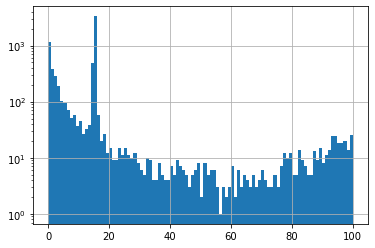

In [9]:
paper_dataset["fuelexp"].hist(bins=100).set_yscale('log')

In [10]:
#paper_dataset["fuel"].hist(bins=100).set_yscale('log')

In [11]:
#paper_dataset[paper_dataset["oil"] == 1]["fuelexp"].hist(bins=100).set_yscale('log')

In [12]:
#paper_dataset[paper_dataset["oil"] == 0]["fuelexp"].hist(bins=100).set_yscale('log')

In [13]:
#paper_dataset[paper_dataset["oil"] == 1]["fuel"].hist(bins=100).set_yscale('log')

In [14]:
#paper_dataset[paper_dataset["oil"] == 0]["fuelexp"].hist(bins=100).set_yscale('log')

In [15]:
# cid uniquely identifies a country, however in some cases when a country splits we have the 
# same CID for 2 different names in different years. This might be solved by joining on (year, cid)

paper_data_countries = pd.read_stata(ORIGINAL_PAPER_COUNTRY, columns=["country", "cid", "year"]).drop_duplicates()
#paper_data_countries.sample(10)
#paper_data_countries[paper_data_countries[["year", "cid"]].duplicated(keep=False)]

#paper_data_countries[paper_data_countries["country"] == "Czechoslovakia"]

In [16]:
# Note to future selves: we lost Korea 1945-1949
paper_data_merged = paper_data_countries.merge(paper_dataset, on=["cid", "year"])

In [17]:
paper_data_merged.sample(5)

country    cid    year  Unnamed: 0  atwards     X     id  cowcode  \
6907   Yemen AR  167.0  1948.0        6908        0  9300  156.0      678   
6954   Yemen PR  168.0  1972.0        6955        0  9380  157.0      680   
2824      India   69.0  1951.0        2825        0  3815   63.0      750   
6767  Venezuela  163.0  1946.0        6768        0  9074  152.0      101   
3040    Ireland   73.0  1947.0        3041        0  4035   67.0      205   

      warstds  ptime  ...  decade1  decade2  decade3  decade4  independ   tip  \
6907        0     48  ...        0        0        0        0         1  23.0   
6954        0     72  ...        0        1        0        0         1   5.0   
2824        0     48  ...        0        0        0        0         1   2.0   
6767        0     24  ...        0        0        0        0         1  44.0   
3040        0     36  ...        0        0        0        0         1  26.0   

      anocracy  proxregc  sxpnew.2   sxpsq.2  
6907         0  1.000000 -0.447948 -0.447948  
6954         0  0.003906  0.108328  0.108328  
2824         0  1.000000  0.054421  0.054421  
6767         1  1.000000  0.092219  0.092219  
3040         0  1.000000  0.091231  0.091231  

[5 rows x 287 columns]

In [18]:
paper_data_merged[["country", "fuelexp", "year"]].sample(5)

country    fuelexp    year
4771    Norway  50.276829  1982.0
1217     Chile   0.097133  1972.0
2176     Gabon  45.170441  1972.0
6899     Yemen  95.300003  1996.0
6924  Yemen AR  14.612738  1965.0

#### Heatmaps

In [19]:
def plot_val_by_country_year(df, val, years=None):
    pivot = pd.pivot_table(data=df, columns=["year"], index="country", values=[val])
    pivot.columns = [int(x[1]) for x in pivot.columns]
    
    if years:
        pivot_slice = pivot[years]
    else:
        pivot_slice = pivot
    
    plt.figure(figsize=(20, 40))
    ax = sns.heatmap(pivot_slice, cmap='RdYlGn_r', linewidths=0.5)
    ax.set_title(val)
    plt.show()

In [20]:
# TODO: comment on valid years from heatmaps?
if CFG["plot_heatmaps"]:
    plot_val_by_country_year(paper_data_merged, "fuelexp", years=range(1964, 2001))
    plot_val_by_country_year(paper_data_merged, "illiteracy", years=range(1971, 2001))
    plot_val_by_country_year(paper_data_merged, "infant", years=range(1966, 2001))
    plot_val_by_country_year(paper_data_merged, "life", years=range(1961, 2001))
    #plot_val_by_country_year(paper_data_merged, "gdpgrowth")

## Data wrangling for wars in territories

1. Get a row for each territory there was a war in for each year
2. For each country that was at war, match name with existing database
2. We need some data cleaning: US never had a war in its territory!
3. For each year, add a 'war in' column in the existing database for each country + intensity level


In [21]:
# 1 extra-systemic (state vs non-state in state territory to keep control of the system) <- colonies
# 2 inter-state  
# 3 intra-state
# 4 intra-state internationalized

In [22]:
# In this case, war is fought in location : we got this
ucdp_prio_data[ucdp_prio_data.type_of_conflict == 1].sample(5)

conflict_id                 location territory_name  year  \
875          263                   Angola         Angola  1969   
734          244                  Morocco        Morocco  1954   
280          216  Vietnam (North Vietnam)        Vietnam  1951   
798          254                 Cameroon       Cameroon  1958   
721          241                    Kenya          Kenya  1955   

     intensity_level  cumulative_intensity  type_of_conflict  
875                1                     1                 1  
734                1                     0                 1  
280                2                     1                 1  
798                1                     0                 1  
721                2                     1                 1

In [23]:
# Not clear where the conflict was: however, only 48 conflicts: we can classify manually
ucdp_prio_data[ucdp_prio_data.type_of_conflict == 2]

conflict_id                                           location  \
2           11343                                      Egypt, Israel   
3           11343                                      Egypt, Israel   
4           11343                                      Egypt, Israel   
5           11343                                      Egypt, Israel   
31          11348                                 South Sudan, Sudan   
...           ...                                                ...   
2277          409                                  Eritrea, Ethiopia   
2354          420  Australia, Iraq, United Kingdom, United States...   
2401          427                                   Tanzania, Uganda   
2414          431                 Afghanistan, Russia (Soviet Union)   
2425          435                                  Djibouti, Eritrea   

      territory_name  year  intensity_level  cumulative_intensity  \
2         Suez/Sinai  1967                2                     1   
3         Suez/Sinai  1969                1                     1   
4         Suez/Sinai  1970                1                     1   
5         Suez/Sinai  1973                2                     1   
31     Common border  2012                1                     0   
...              ...   ...              ...                   ...   
2277   Common border  2016                1                     1   
2354             NaN  2003                2                     1   
2401  Kagera Salient  1978                1                     0   
2414             NaN  1979                1                     0   
2425   Common border  2008                1                     0   

      type_of_conflict  
2                    2  
3                    2  
4                    2  
5                    2  
31                   2  
...                ...  
2277                 2  
2354                 2  
2401                 2  
2414                 2  
2425                 2  

[131 rows x 7 columns]

In [24]:
# In this case, war is fought in location : we got this
ucdp_prio_data[ucdp_prio_data.type_of_conflict == 3].sample(5)

conflict_id         location    territory_name  year  intensity_level  \
676           234           Israel         Palestine  1993                1   
1229          291        Indonesia        West Papua  1981                2   
1913          351            India  Punjab/Khalistan  1993                1   
897           264  Myanmar (Burma)              Shan  1978                1   
2434          439  Myanmar (Burma)            Kokang  2015                1   

      cumulative_intensity  type_of_conflict  
676                      1                 3  
1229                     1                 3  
1913                     1                 3  
897                      1                 3  
2434                     0                 3

In [25]:
#ucdp_prio_data[(ucdp_prio_data.type_of_conflict == 3) & (ucdp_prio_data.intensity_level == 1) & (ucdp_prio_data.location == 'United Kingdom')]

In [26]:
#ucdp_prio_data[(ucdp_prio_data.type_of_conflict != 2) & (ucdp_prio_data.location.str.contains('United States'))]

In [27]:
# Idea: always match countries with others that have the same intensity of war. Keep all intensities. 

## Selecting useful columns from datasets and merging on conflict id
To know the geographic location of war we merge the USCP/PRIO dataset with the disgragated dataset(ged-201) in order to have a new dataset with important information for data analysis. So we did a filtering on the columns of the two datasets and we merged using the feature conflic_id_new, for the disgragated dataset, and the feature conflict_id for the USCD/PRIO dataset. These two features are fully compatible and identify a specific conflict.
Using USCP dataset we select conflicts with types of conflict equal to 1, 3 or 4 (extrasystemic, intrastate, internationalzed intrastate) because in these cases the location correspond to the geografic location which is not true in general. For conflicts of type 2 (interstates) we use the merging as described above for conflicts starting from 1989, for the others we 'build' the geographic location manually using the geografic area. 

In [28]:
# merging ged_201 and ucdp_prio 
#conflict_merged = pd.merge(ged_201, ucdp_prio_data, left_on= ['conflict_new_id','year'], right_on =['conflict_id','year']).drop_duplicates()

In [29]:
#conflict_merged[(conflict_merged['year']>1959) & (conflict_merged['year']<=2000)].sample(5)

In [30]:
#if "conflict_new_id" in conflict_merged:
#    conflict_merged.drop('conflict_new_id', axis=1, inplace=True)
#    print ("Done")

In [31]:
#conflict_merged[conflict_merged['conflict_id']==315]
#ged_201[ged_201['conflict_new_id']==315].year
ged_201['year'].min()

1989

#### Selecting conflicts of types (1,3,4)

Select conflicts of type 1, 3 and 4 between 1961 and 2000 where "location" means geographic location.

In [32]:
# Filter years between 1961 and 2000
ucdp_prio_data_1961_2000 = ucdp_prio_data[(ucdp_prio_data['year']>1960) & (ucdp_prio_data['year']<=2000)]
# filter conflicts of type 1, 3, 4 between 1961 and 2000
ucdp_prio_data_134 = ucdp_prio_data_1961_2000[ucdp_prio_data_1961_2000['type_of_conflict'] != 2]

#### Selecting conflicts of type 2 after the 1989

In [33]:
# filter conflicts of type 2 between 1961 and 2000
ucdp_prio_data_2 = ucdp_prio_data_1961_2000[ucdp_prio_data_1961_2000['type_of_conflict'] == 2]

In [34]:
# view conflicts of type 2 between 1961 and 2000
ucdp_prio_data_2[ucdp_prio_data_2['year']>1988].head()

conflict_id         location territory_name  year  intensity_level  \
291          218  India, Pakistan        Kashmir  1989                1   
292          218  India, Pakistan        Kashmir  1990                1   
293          218  India, Pakistan        Kashmir  1991                1   
294          218  India, Pakistan        Kashmir  1992                1   
295          218  India, Pakistan        Kashmir  1996                1   

     cumulative_intensity  type_of_conflict  
291                     1                 2  
292                     1                 2  
293                     1                 2  
294                     1                 2  
295                     1                 2

In [35]:
# merging with ged_201 to have the geographical location for conflicts after 1989
ucdp_2_after1989 = pd.merge(ged_201, ucdp_prio_data_2, 
                            left_on= ['conflict_new_id','year'], 
                            right_on =['conflict_id','year']).drop_duplicates()

In [36]:
# drop "location" and "conflict_new_id", then rename country to "location". 
# Now location is geographical location

ucdp_2_drop_cols = ["conflict_new_id", "location"]
if all([col in ucdp_2_after1989 for col in ucdp_2_drop_cols]):
    ucdp_2_after1989.drop(ucdp_2_drop_cols, axis=1, inplace=True)
    print(f"Dropped: {ucdp_2_drop_cols}")

ucdp_2_after1989.rename(columns = {"country" : "location"}, inplace=True)
ucdp_2_after1989.sample(5)

Dropped: ['conflict_new_id', 'location']


year  location  conflict_id         territory_name  intensity_level  \
3    1995   Ecuador          403  Cordillera del Condor                1   
60   2000  Ethiopia          409          Common border                2   
242  1990    Kuwait          371                 Kuwait                2   
51   1999  Ethiopia          409          Common border                2   
69   1991     India          218                Kashmir                1   

     cumulative_intensity  type_of_conflict  
3                       0                 2  
60                      1                 2  
242                     1                 2  
51                      1                 2  
69                      1                 2

#### Selecting manually the location of interstate conflicts (2) before 1989

In [37]:
# before 1970
ucdp_before_1970 = ucdp_prio_data_2[ucdp_prio_data_2['year'] < 1970].copy()
ucdp_before_1970["location"] = ucdp_before_1970["location"].str.split(', ') # split on comma
ucdp_before_1970_exp = ucdp_before_1970.explode("location") # explode split rows

ucdp_before_1970_exp.index = range(2500, 2500+len(ucdp_before_1970_exp)) # reassign index 
ucdp_before_1970_exp.sample(5) 

conflict_id                 location                 territory_name  \
2514          274                    China  Aksai Chin, Arunachal Pradesh   
2520          281                Indonesia                   North Borneo   
2529          293  Vietnam (North Vietnam)                  South Vietnam   
2504          218                    India                        Kashmir   
2502        11343                    Egypt                     Suez/Sinai   

      year  intensity_level  cumulative_intensity  type_of_conflict  
2514  1967                1                     1                 2  
2520  1963                1                     0                 2  
2529  1965                2                     1                 2  
2504  1964                1                     1                 2  
2502  1969                1                     1                 2

In [38]:
# Drop countries where the war did not take place
udcp_before_1970_manual = ucdp_before_1970_exp.drop([
    2501, # Israel Suez
    2503, # Israel Suez
    2509, # Somalia Ogaden
    2510, # France 1961 (vs Tunisia)
    2517, # France 1961 (vs Tunisia)
    2529, # North Vietnam 1965
    2531, # North Vietnam 1965
    2533, # North Vietnam 1965
    2535, # North Vietnam 1965
    2537, # North Vietnam 1965
    2540, # Israel Golan
])

In [39]:
# Same as above for conflicts between 1980 and 1988
df_1988 = ucdp_prio_data[(ucdp_prio_data.type_of_conflict == 2) & (ucdp_prio_data.year >= 1980) & (ucdp_prio_data.year<=1988)].copy()
df_1988["location"] = df_1988["location"].str.split(', ')
df_1988_exploded = df_1988.explode("location")
df_1988_exploded.index = range(2700, 2700+len(df_1988_exploded))
udcp_before_1988_manual = df_1988_exploded.drop([2739, 2743, 2707])

In [40]:
# Same as above for conflicts between 1970 and 1980
ucdp_before_1980 = ucdp_prio_data_2[(ucdp_prio_data_2['year']>1970) & (ucdp_prio_data_2['year']<1980)].copy()
ucdp_before_1980["location"] = ucdp_before_1980["location"].str.split(', ')
ucdp_before_1980_exp = ucdp_before_1980.explode("location")
ucdp_before_1980_exp.index = list(range(2600, 2600+len(ucdp_before_1980_exp)))
ucdp_before_1980_manual = ucdp_before_1980_exp.drop([2601 # Israel Suez
                           ,2605 # Somalia Ogaden
                           ,2607,# Somalia Ogaden
                           2609, # Somalia Ogaden
                           2611, #North Vietnam
                           2613, #North Vietnam
                           2615, #North Vietnam
                           2617, #North Vietnam
                           2622, #Israel Golan
                           2629, #Turkey north cyprus
                           2645, #Uganda Kagera Salient
                           2647, #Russia
                          ])

In [41]:
# concatenate all conflicts of level 2
ucdp_manual = pd.concat([udcp_before_1970_manual, ucdp_before_1980_manual, udcp_before_1988_manual])
ucdp_conflict_level2 = pd.concat([ucdp_manual, ucdp_2_after1989])
ucdp_conflict_level2.sample(5)

conflict_id                 location territory_name  year  \
2608          293            South Vietnam  South Vietnam  1971   
2727          334  Vietnam (North Vietnam)        Various  1981   
2708          324                     Iran        Various  1981   
2711          324                     Iraq        Various  1982   
2532          293            South Vietnam  South Vietnam  1967   

      intensity_level  cumulative_intensity  type_of_conflict  
2608                2                     1                 2  
2727                1                     1                 2  
2708                2                     1                 2  
2711                2                     1                 2  
2532                2                     1                 2

In [42]:
# concatenate all conflicts
filtercols = ["location", "year", "conflict_id", "intensity_level", 
              "cumulative_intensity", "territory_name"]#, "region"]
ucdp_wrangled = pd.concat([ucdp_prio_data_134, ucdp_conflict_level2])[filtercols].sort_values(by="year")

ucdp_wrangled.sample(5)

location  year  conflict_id  intensity_level  cumulative_intensity  \
1565  Bangladesh  1985          322                1                     0   
866         Laos  1990          262                1                     1   
629    Guatemala  1993          233                1                     1   
181         Iran  1982          205                2                     1   
970       France  1962          270                2                     1   

              territory_name  
1565  Chittagong Hill Tracts  
866                      NaN  
629                      NaN  
181                Kurdistan  
970                      NaN

In [43]:
# Standardize names
name_map = {
    "Bosnia" : "Bosnia-Herzegovina",
    "Cambodia (Kampuchea)" : "Cambodia",
    "Congo" : "Congo (Braz)",
    "Zaire/Congo" : "DR Congo (Zaire)",
    "Guinea Bissau" : "Guinea-Bissau",
    "Papua NG" : "Papua New Guinea",
    "Madagascar (Malagasy)" : "Madagascar",
    "Myanmar/Burma" : "Myanmar (Burma)",
    "USSR/Russia" : "Russia (Soviet Union)",
    "Serbia (Yugoslavia)" : "Yugoslavia",
    "Trinidad" : "Trinidad and Tobago",
    "United Kingdom" : "U.K.",
    "Yemen (North Yemen)" : "Yemen", # TODO: review
    "South Yemen" : "Yemen", # TODO: review
    "Zimbabwe (Rhodesia)" : "Zimbabwe",
    "Vietnam (North Vietnam)" : "Vietnam"
}


# substitute names
#paper_features = ["country", "life", "fuelexp", "year", "illiteracy", "infant"]
#paper_wellbeing = paper_data_merged[paper_features].copy()
paper_wellbeing = paper_data_merged # rename
paper_wellbeing.country = [name_map.get(x, x) for x in paper_wellbeing.country]
ucdp_wrangled.location = [name_map.get(x, x) for x in ucdp_wrangled.location]

# year as int
paper_wellbeing.year = paper_wellbeing.year.astype(int)

# rename Vietnam before unification to South Vietnam
# Data before unification is very likely only from South Vietnam
vietnam_index = paper_wellbeing[(paper_wellbeing["country"] == "Vietnam") & (paper_wellbeing["year"] < 1976)].index
paper_wellbeing.loc[vietnam_index, "country"] = "South Vietnam"

In [44]:
# drop North Vietnam before 1976
dropped_vietnam = False
if not dropped_vietnam:
    ucdp_wrangled.drop([2639, 2633], inplace=True)
    dropped_vietnam = True

In [45]:
# change Russia to USSR in 1990 and 1991 (this is likely a mistake)
russia_index = paper_wellbeing[(paper_wellbeing["country"] == "Russia") & (paper_wellbeing["year"] <= 1991)].index
paper_wellbeing.loc[russia_index, "country"] = "Russia (Soviet Union)"

# change USSR after 1992 to Russia
ussr_index = ucdp_wrangled[(ucdp_wrangled["location"] == "Russia (Soviet Union)") & (ucdp_wrangled["year"] > 1991)].index
ucdp_wrangled.loc[ussr_index, "location"] = "Russia"

In [46]:
ucdp_paper_outerjoin = paper_wellbeing.merge(ucdp_wrangled, how='outer', 
                                             left_on=["country", "year"], 
                                             right_on=["location", "year"])
ucdp_paper_outerjoin.sample(5)

country    cid  year  Unnamed: 0  atwards       X     id  \
4708  Myanmar (Burma)  106.0  1989      4381.0      1.0  5925.0   94.0   
4937      New Zealand  110.0  1991      4587.0      0.0  6151.0   98.0   
5130           Norway  114.0  1990      4780.0      0.0  6374.0  102.0   
5721           Rwanda  126.0  1979      5339.0      0.0  7035.0  116.0   
7169        Venezuela  163.0  1948      6770.0      0.0  9076.0  152.0   

      cowcode  warstds  ptime  ...        tip  anocracy      proxregc  \
4708    775.0      0.0  212.0  ...  18.260735       0.0  8.880000e-16   
4937    920.0      0.0  564.0  ...  72.000000       0.0  0.000000e+00   
5130    385.0      0.0  552.0  ...  86.000000       0.0  0.000000e+00   
5721    517.0      0.0  178.0  ...  14.000000       0.0  1.460000e-11   
7169    101.0      0.0   48.0  ...  46.000000       1.0  1.000000e+00   

      sxpnew.2   sxpsq.2         location  conflict_id  intensity_level  \
4708 -0.459557 -0.459557  Myanmar (Burma)        221.0              2.0   
4937  0.089216  0.089216              NaN          NaN              NaN   
5130  0.308141  0.308141              NaN          NaN              NaN   
5721  0.096053  0.096053              NaN          NaN              NaN   
7169  0.093514  0.093514              NaN          NaN              NaN   

      cumulative_intensity  territory_name  
4708                   1.0           Karen  
4937                   NaN             NaN  
5130                   NaN             NaN  
5721                   NaN             NaN  
7169                   NaN             NaN  

[5 rows x 292 columns]

In [47]:
# check which names in ucdp_wrangled and paper_wellbeing don't overlap
x = ucdp_paper_outerjoin.country.unique().astype(str)
y = ucdp_paper_outerjoin.location.unique().astype(str)
print("in paper_wellbeing, not in ucdp_wrangled:\n", np.setdiff1d(x, y))
print("in ucdp_wrangled, not in paper_wellbeing:\n", np.setdiff1d(y, x))

in paper_wellbeing, not in ucdp_wrangled:
 ['Albania' 'Armenia' 'Australia' 'Austria' 'Bahamas' 'Bahrain' 'Barbados'
 'Belarus' 'Belgium' 'Belize' 'Benin' 'Bhutan' 'Botswana' 'Brazil'
 'Bulgaria' 'C.A.R.' 'Canada' 'Cape Verde' 'Costa Rica' 'Czech Republic'
 'Czechoslovakia' 'Denmark' 'Estonia' 'Fiji' 'Finland' 'Germany' 'Greece'
 'Guyana' 'Hungary' 'Iceland' 'Ireland' 'Italy' 'Ivory Coast' 'Jamaica'
 'Japan' 'Kazakhstan' 'Korea, South' 'Kyrgyzstan' 'Latvia' 'Lithuania'
 'Luxembourg' 'Macedonia' 'Malawi' 'Malta' 'Mauritius' 'Mongolia'
 'Namibia' 'Netherlands' 'New Zealand' 'Norway' 'Poland' 'Portugal'
 'Qatar' 'Seychelles' 'Singapore' 'Slovakia' 'Slovenia' 'Solomon Islands'
 'Swaziland' 'Sweden' 'Switzerland' 'Taiwan' 'Turkmenistan' 'U.A.R.'
 'U.S.A.' 'Ukraine' 'Vanuatu' 'Western Samoa' 'Yemen AR' 'Yemen PR'
 'Zambia']
in ucdp_wrangled, not in paper_wellbeing:
 ['Brunei']


In [48]:
# copy location column to country when country is null, then drop location
joined = ucdp_paper_outerjoin.copy()
joined.loc[joined.country.isnull(), "country"] = joined.loc[joined.country.isnull(), "location"]

# drop location
if "location" in joined:
    joined.drop("location", inplace=True, axis=1)
    print("Done")

Done


In [49]:
# add new binary column for when the country is at war
# NOTE: "war" in this case is generic war of any type

joined["war"] = (~joined.conflict_id.isnull()).astype(int)
joined.sample(5)

country    cid  year  Unnamed: 0  atwards       X     id  \
6587         Thailand  148.0  1953      6195.0      0.0  8241.0  139.0   
5610         Portugal  123.0  1993      5228.0      0.0  6881.0  111.0   
304           Austria    8.0  1945       299.0      0.0   393.0    6.0   
4678  Myanmar (Burma)  106.0  1982      4374.0      1.0  5918.0   94.0   
3543            Japan   78.0  1992      3332.0      0.0  4360.0   72.0   

      cowcode  warstds  ptime  ...         tip  anocracy      proxregc  \
6587    800.0      0.0  108.0  ...   67.000000       0.0  1.000000e+00   
5610    235.0      0.0  588.0  ...  160.000000       0.0  2.330000e-10   
304     305.0      0.0   12.0  ...   12.000000       0.0  1.434609e-01   
4678    775.0      0.0  211.0  ...   18.003882       0.0  1.460000e-11   
3543    740.0      0.0  576.0  ...  116.000000       0.0  3.310000e-24   

      sxpnew.2   sxpsq.2  conflict_id  intensity_level  cumulative_intensity  \
6587  0.092463  0.092463          NaN              NaN                   NaN   
5610 -1.128782 -1.128782          NaN              NaN                   NaN   
304   0.094291  0.094291          NaN              NaN                   NaN   
4678 -0.456634 -0.456634        222.0              2.0                   1.0   
3543 -1.444326 -1.444326          NaN              NaN                   NaN   

      territory_name  war  
6587             NaN    0  
5610             NaN    0  
304              NaN    0  
4678             NaN    1  
3543             NaN    0  

[5 rows x 292 columns]

## Income inequality

In [50]:
import glob
ineq_csv_files = glob.glob(WID_DATA_FOLDER + '/*_data*.csv')

wid_gini_usecols = ["country", "year", "variable", "value"]
ineq_df_list = [pd.read_csv(csv, sep=';', keep_default_na=False, usecols=wid_gini_usecols) 
                for csv in ineq_csv_files]

In [51]:
# get country indices
ineq_countries = pd.read_csv(WID_DATA_FOLDER + '/WID_countries.csv', sep=';', usecols=["alpha2", "shortname"])
ineq_countries_map = {code : name for code, name in zip(ineq_countries["alpha2"], ineq_countries["shortname"])}
ineq_countries_map

{'AM': 'Armenia',
 'AN': 'Netherlands Antilles',
 'AO': 'Angola',
 'AR': 'Argentina',
 'AS': 'American Samoa',
 'AT': 'Austria',
 'AU': 'Australia',
 'AW': 'Aruba',
 'AZ': 'Azerbaijan',
 'BA': 'Bosnia and Herzegovina',
 'BB': 'Barbados',
 'BD': 'Bangladesh',
 'BE': 'Belgium',
 'BF': 'Burkina Faso',
 'BG': 'Bulgaria',
 'BH': 'Bahrain',
 'BI': 'Burundi',
 'BJ': 'Benin',
 'BM': 'Bermuda',
 'BN': 'Brunei Darussalam',
 'BO': 'Bolivia',
 'BR': 'Brazil',
 'BS': 'Bahamas',
 'BT': 'Bhutan',
 'BW': 'Botswana',
 'BY': 'Belarus',
 'BZ': 'Belize',
 'CA': 'Canada',
 'CD': 'DR Congo',
 'CF': 'Central African Republic',
 'CG': 'Congo',
 'CH': 'Switzerland',
 'CI': "Cote d'Ivoire",
 'CK': 'Cook Islands',
 'CL': 'Chile',
 'CM': 'Cameroon',
 'CN': 'China',
 'CN-RU': 'Rural China',
 'CN-UR': 'Urban China',
 'CO': 'Colombia',
 'CR': 'Costa Rica',
 'CS': 'Czechoslovakia',
 'CU': 'Cuba',
 'CV': 'Cabo Verde',
 'CW': 'Curacao',
 'CY': 'Cyprus',
 'CZ': 'Czech Republic',
 'DD': 'German Democratic Republic',
 'DE

In [52]:
ineq_full_raw = pd.concat(ineq_df_list) # join all files

# filter interesting rows
ineq_gini = ineq_full_raw[(ineq_full_raw["variable"] == "gptinc992j") & 
                          (ineq_full_raw["year"] > 1960) & 
                          (ineq_full_raw["year"] <= 2000)].copy()

del ineq_full_raw # free up some memory
ineq_gini.sample(5)

country    variable  year     value
12802      WO  gptinc992j  1984  0.644660
25903      BI  gptinc992j  1991  0.516845
29331      JO  gptinc992j  1992  0.581255
19708      ZZ  gptinc992j  1993  0.532552
8763       CG  gptinc992j  1996  0.641285

In [53]:
# rename country code with country names
ineq_gini.country = [ineq_countries_map.get(c, c) for c in ineq_gini.country]

# rename gini column
ineq_gini.rename(columns = {"value" : "gini"}, inplace=True)

# drop "variable column"
if "variable" in ineq_gini:
    ineq_gini.drop("variable", axis=1, inplace=True)
    print("Done")

ineq_gini.sample(5)

Done


country  year      gini
83473                          Austria  1998  0.405918
38993                            Ghana  1993  0.562978
3943                           Eritrea  1994  0.639680
7405   Middle East and Northern Africa  1993  0.742065
17908                     Saudi Arabia  1993  0.715726

In [54]:
ineq_rename = {
    "Bosnia and Herzegovina" : "Bosnia-Herzegovina",
    "Cabo Verde" : "Cape Verde",
    "Central African Republic" : "C.A.R.",
    "Congo" : "Congo (Braz)",
    "DR Congo" : "DR Congo (Zaire)",
    "German Democratic Republic" : "Germany",
    "Russian Federation" : "Russia",
    "Syrian Arab Republic" : "Syria",
    "USA" : "U.S.A.",
    "United Kingdom" : "U.K.",
    "United Arab Emirated" : "U.A.R.",
    "Cote d'Ivoire" : "Ivory Coast"
}
ineq_gini.country = [ineq_rename.get(c, c) for c in ineq_gini.country]

In [55]:
x = ineq_gini.country.unique().astype(str)
y = joined.country.unique().astype(str)
print("in ineq_gini, not in joined:\n", np.setdiff1d(x, y))
print("in joined, not in ineq_gini:\n", np.setdiff1d(y, x))

in ineq_gini, not in joined:
 ['Africa' 'Asia (excl. Middle East)'
 'Asia (excluding Middle East), Market Exchange Rate' 'Eastern Africa'
 'Eastern Europe' 'Equatorial Guinea' 'Europe' 'European Union'
 'Latin America' 'Latin America, Market Exchange Rate' 'Middle Africa'
 'Middle East' 'Middle East and Northern Africa'
 'Middle East and Northern Africa, Market Exchange Rate' 'Montenegro'
 'Northern Africa' 'Northern America' 'Oceania' 'Palestine' 'Rural China'
 'Russia and Ukraine' 'Russia and Ukraine, Market Exchange Rate'
 'Sao Tome and Principe' 'Serbia' 'Southern Africa' 'Sub-Saharan Africa'
 'Sub-Saharan Africa, Market Exchange Rate' 'United Arab Emirates'
 'Urban China' 'Western Africa' 'World' 'World (Market Exchange Rate)'
 'Zanzibar' 'nan']
in joined, not in ineq_gini:
 ['Afghanistan' 'Argentina' 'Armenia' 'Australia' 'Azerbaijan' 'Bahamas'
 'Bangladesh' 'Barbados' 'Belarus' 'Belize' 'Bhutan' 'Bolivia' 'Brazil'
 'Brunei' 'Cambodia' 'Canada' 'Chile' 'Colombia' 'Costa Rica' 'Cu

Lots of countries are missing a Gini coefficient! We should look for another dataset...

In [56]:
#final_df = joined.merge(ineq_gini, how='left', on=["country", "year"])

In [57]:
#for country in country2region:
#    idx = final_df[final_df["country"] == country].index
#    final_df.loc[idx, "gini"] = ineq_gini[ineq_gini["country"] == country2region[country]].gini

## 2nd Gini dataset

In [58]:
wiid_filtercols = ["country", "year", "gini_reported"]
wiid_gini_raw = pd.read_stata(DATA_FOLDER + 'WIID_06MAY2020.dta', columns=wiid_filtercols)

In [59]:
gini_years = wiid_gini_raw[(wiid_gini_raw.year > 1960) & (wiid_gini_raw.year <= 2000)].copy()
gini_years.sample(5)

country    year  gini_reported
8447        Poland  1993.0           31.7
918        Bolivia  1990.0           54.5
1532        Canada  1987.0           28.3
7421   New Zealand  1985.0           40.8
10188     Tanzania  1964.0           54.0

In [60]:
#print(np.setdiff1d(final_df.country, gini_years.country))
#print(np.setdiff1d(gini_years.country, final_df.country))

In [61]:
# rename countries
gini_2_mapping = {
    'Bahamas, The' : 'Bahamas',
    'Bosnia and Herzegovina' : 'Bosnia-Herzegovina',
    'Central African Republic' : 'C.A.R.',
    "Cote d'Ivoire" : 'Ivory Coast',
    'Czechia' : 'Czech Republic',
    'Eswatini' : 'Swaziland',
    'Gambia, The' : 'Gambia',
    'Korea, Republic of' : 'Korea, South',
    'North Macedonia' : 'Macedonia',
    'Serbia and Montenegro' : 'Serbia',
    'Soviet Union' : 'Russia (Soviet Union)',
    'United Kingdom' : 'U.K.',
    'United States' : 'U.S.A.'
}

gini_years.country = gini_years.country.apply(lambda c : gini_2_mapping[c] if c in gini_2_mapping else c)

In [62]:
# Take mean of all reported gini values
gini_by_country_year = gini_years.groupby(['country', 'year']).mean()

# standardize gini units
gini_by_country_year.gini_reported = gini_by_country_year.gini_reported.apply(lambda x : x/100)

gini_by_country_year.reset_index(inplace=True)
gini_by_country_year.rename(columns = {"gini_reported" : "gini"}, inplace=True)


gini_by_country_year.sample(5)

country    year      gini
1846       Zambia  1970.0  0.618000
1106      Moldova  1989.0  0.253000
649       Germany  1983.0  0.280500
1290  Philippines  1988.0  0.433167
1837   Yugoslavia  1983.0  0.264000

In [63]:
# join 1st and 2nd gini datasets
gini_final = pd.concat([ineq_gini, gini_by_country_year]).groupby(['country', 'year']).mean()
gini_final.reset_index(inplace=True)
gini_final.sample(5)

country    year      gini
1700   Luxembourg  1993.0  0.446865
2205         Peru  1972.0  0.570000
2324  Rural China  1997.0  0.431485
1317    Indonesia  1999.0  0.296600
2123      Oceania  1993.0  0.680193

In [64]:
# join with conflict data
final_df = joined.merge(gini_final, how='left', on=["country", "year"])
final_df.sample(5)

country    cid  year  Unnamed: 0  atwards       X    id  \
2850          Iceland   68.0  1951      2770.0      0.0  3759.0  62.0   
588             Benin   17.0  1968       582.0      0.0   920.0  14.0   
4243             Mali   97.0  1994      4028.0      0.0  5426.0  85.0   
4586  Myanmar (Burma)  106.0  1964      4356.0      0.0  5900.0  94.0   
2940            India   69.0  1978      2852.0      0.0  3842.0  63.0   

      cowcode  warstds  ptime  ...  anocracy      proxregc  sxpnew.2  \
2850    395.0      0.0   84.0  ...       0.0  5.420000e-20  0.089641   
588     434.0      0.0  108.0  ...       0.0  6.250000e-02 -1.020189   
4243    432.0      0.0  386.0  ...       0.0  2.500000e-01  0.034999   
4586    775.0      0.0  168.0  ...       0.0  1.000000e+00 -0.036872   
2940    750.0      0.0  371.0  ...       0.0  5.550000e-17 -1.235702   

       sxpsq.2  conflict_id  intensity_level  cumulative_intensity  \
2850  0.089641          NaN              NaN                   NaN   
588  -1.020189          NaN              NaN                   NaN   
4243  0.034999        372.0              1.0                   0.0   
4586 -0.036872        231.0              2.0                   1.0   
2940 -1.235702          NaN              NaN                   NaN   

      territory_name  war      gini  
2850             NaN    0       NaN  
588              NaN    0       NaN  
4243          Azawad    1  0.658589  
4586          Kachin    1       NaN  
2940             NaN    0  0.386030  

[5 rows x 293 columns]

In [65]:
# deal with nans
final_df.intensity_level = final_df.intensity_level.apply(lambda x : 0 if np.isnan(x) else x)
final_df.cumulative_intensity = final_df.cumulative_intensity.apply(lambda x : 0 if np.isnan(x) else 1 if x == 1 else 2)

In [66]:
# rename wellbeing
wellbeing_features = ["life", "fuelexp", "war", "illiteracy", "infant", "intensity_level", "cumulative_intensity", "gini"]
used_columns = sorted(list(set(["ager", "agexp", "anoc", "army85", "autch98", "auto4",
    "autonomy", "avgnabo", "centpol3", "coldwar", "decade1", "decade2",
    "decade3", "decade4", "dem", "dem4", "demch98", "dlang", "drel", "durable",
    "ef", "ef2", "ehet", "elfo", "elfo2", "etdo4590", "expgdp", "exrec",
    "fedpol3", "fuelexp", "gdpgrowth", "geo1", "geo2", "geo34", "geo57",
    "geo69", "geo8", "illiteracy", "incumb", "infant", "inst", "inst3", "life",
    "lmtnest", "ln_gdpen", "lpopns", "major", "manuexp", "milper", "mirps0",
    "mirps1", "mirps2", "mirps3", "nat_war", "ncontig", "nmgdp", "nmdp4_alt",
    "numlang", "nwstate", "oil", "p4mchg", "parcomp", "parreg", "part",
    "partfree", "plural", "plurrel", "pol4", "pol4m", "pol4sq", "polch98",
    "polcomp", "popdense", "presi", "pri", "proxregc", "ptime", "reg",
    "regd4_alt", "relfrac", "seceduc", "second", "semipol3", "sip2", "sxpnew",
    "sxpsq", "tnatwar", "trade", "warhist", "xconst", "oil33"] + ["year", "country"]).union(set(wellbeing_features))))

Because many countries are missing Gini score values, we will do our analyses with and without the Gini score as a feature

In [67]:
# create a binary feature for countries that export more than 33% of GDP as fuel
final_df["oil33"] = (final_df["fuelexp"] > 33).astype(int)
df_gini = final_df[(final_df.year > 1960) & (final_df.year <= 2000)][used_columns]

df_gini_clean = df_gini.dropna() # dataset with 'gini' column, without nans

In [68]:
df_no_gini = df_gini.drop('gini', axis=1)
df_no_gini_clean = df_no_gini.dropna() # dataset without 'gini' column, without nans

# 1. Is oil correlated with a country's wellbeing?

Is there a correlation between abundance/high exports of oil in a country and its population's wellbeing?

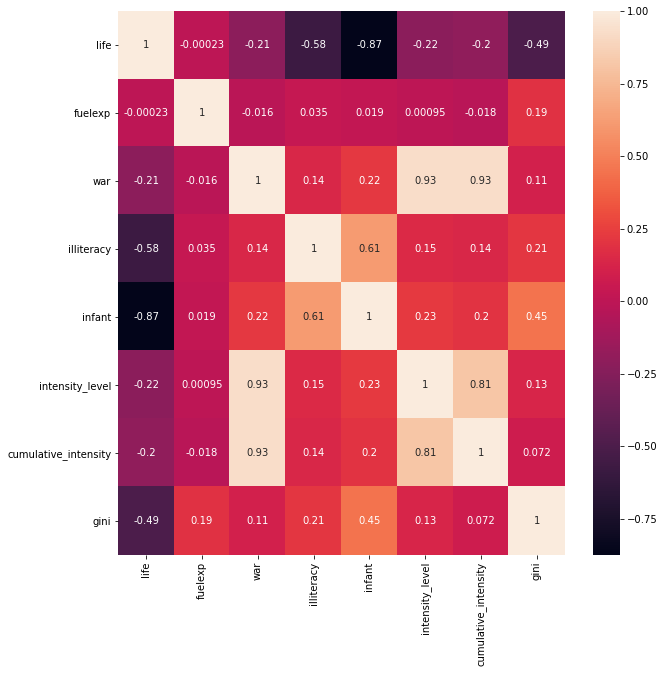

In [69]:
plt.figure(figsize=(10,10))
#df_part_1 = final_df[(final_df.year > 1960) & (final_df.year <= 2000)]
corrMatrix = final_df[wellbeing_features].corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

With the current data, we can see no correlation between oil export and any of the variable that is an index of well-being. As a consequence, it does not make sense to look for causation.
The only possibly relevant feature is the gini index. Further integrations of the Gini score into the dataset may be necessary.

## 2. What are the variables that have the most influence in the prediction of a war?

1. Use random forests to predict a war in a country
3. Use the gini index to check the variables' importance - a la replication
4. If gini index seems to be relevant, integrate more data

intensity_level: nan -> 0
cumulative_intensity: 1 - > 2, 0 -> 1, nan -> 0

In [70]:
drop_cols = ['war', 'year', 'country', 'intensity_level', 'cumulative_intensity', 'milper', 'army85', 'sxpsq', 'elfo2', 'ef2']
x_df_no_gini = df_no_gini_clean.drop(drop_cols, axis=1)
y_df_no_gini = df_no_gini_clean.war
x_df_gini = df_gini_clean.drop(drop_cols, axis=1)
y_df_gini = df_gini_clean.war

In [71]:
df_no_gini_clean.war.values.sum()/len(df_no_gini_clean)

0.22898689677213166

In [72]:
df_gini_clean.war.values.sum()/len(df_gini_clean)

0.218609865470852

## Cross Validation

In [73]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import f1_score
from sklearn.ensemble import  RandomForestClassifier

In [74]:
x_train, x_test, y_train, y_test = train_test_split(x_df_no_gini, y_df_no_gini, test_size=0.2)

In [75]:
# TODO select variables on importance mass e.g. >= 25%

n_estimators_list = range(50, 450, 50) if CFG["cross_val"] else [100]

score_means = []

for e in n_estimators_list:
    rf = RandomForestClassifier(n_estimators=e)
    scores = cross_val_score(rf, x_train, y_train, cv=10, scoring='f1')
    mean_score = np.mean(scores)
    score_means.append((rf, mean_score))
    print (f"n_estimators: {e}, mean score: {mean_score}")

rf_best, _ = max(score_means, key = lambda x : x[1])

n_estimators: 100, mean score: 0.8717208220725297


In [76]:
rf_best.fit(x_train, y_train)
rf_best.score(x_test, y_test)

0.9488817891373802

In [77]:
f1_score(rf.predict(x_test), y_test)

0.8840579710144927

In [78]:
list(reversed(sorted(list(zip(rf_best.feature_importances_, x_train.columns)))))[:25]

[(0.05843052633406671, 'sxpnew'),
 (0.05544948573978658, 'lpopns'),
 (0.04285726501275681, 'nmgdp'),
 (0.040208566453322846, 'trade'),
 (0.03495883329530738, 'numlang'),
 (0.03297972483807128, 'illiteracy'),
 (0.03274704036742196, 'agexp'),
 (0.03166003570349572, 'ln_gdpen'),
 (0.030973287177945664, 'expgdp'),
 (0.03030882962894934, 'ehet'),
 (0.025507411301643856, 'popdense'),
 (0.024813671242623632, 'lmtnest'),
 (0.024455229363894333, 'dlang'),
 (0.024305215878365493, 'ptime'),
 (0.02129756048820009, 'warhist'),
 (0.02001309961426544, 'elfo'),
 (0.01973214569531436, 'ager'),
 (0.018374476413051757, 'avgnabo'),
 (0.01830290702347687, 'fuelexp'),
 (0.01754331526255581, 'tnatwar'),
 (0.017034051757563666, 'infant'),
 (0.016882335795178647, 'drel'),
 (0.0168161030414844, 'second'),
 (0.016525562634388098, 'manuexp'),
 (0.016052913227356906, 'life')]

In [79]:
rf_notest = RandomForestClassifier()
rf_notest.fit(x_df_no_gini, y_df_no_gini)
top_N = 10
top_no_gini = [x[1] for x in 
               reversed(sorted(zip(rf_notest.feature_importances_, x_df_no_gini.columns), key = lambda x : x[0]))][:top_N]
top_no_gini

['sxpnew',
 'lpopns',
 'nmgdp',
 'expgdp',
 'trade',
 'numlang',
 'illiteracy',
 'lmtnest',
 'agexp',
 'popdense']

In [80]:
feature_imp_no_gini = rf_notest.feature_importances_
feature_names_no_gini = x_df_no_gini.columns

In [81]:
x_train, x_test, y_train, y_test = train_test_split(x_df_gini, y_df_gini, test_size=0.2)

In [82]:
n_estimators_list = range(50, 450, 50) if CFG["cross_val"] else [100]

score_means = []

for e in n_estimators_list:
    rf = RandomForestClassifier(n_estimators=e)
    scores = cross_val_score(rf, x_train, y_train, cv=10, scoring='f1')
    mean_score = np.mean(scores)
    score_means.append((rf, mean_score))
    print (f"n_estimators: {e}, mean score: {mean_score}")

rf_best, _ = max(score_means, key = lambda x : x[1])

n_estimators: 100, mean score: 0.8432943682897429


In [83]:
rf_best.fit(x_train, y_train)
rf_best.score(x_test, y_test)

0.9514925373134329

In [84]:
f1_score(rf.predict(x_test), y_test)

0.8839285714285715

In [85]:
list(reversed(sorted(list(zip(rf_best.feature_importances_, x_train.columns)))))[:25]

[(0.05932353889940161, 'illiteracy'),
 (0.05085454781392536, 'sxpnew'),
 (0.0431066225486865, 'ehet'),
 (0.03488747103604549, 'numlang'),
 (0.03311824369673504, 'trade'),
 (0.03239976631975563, 'lpopns'),
 (0.03210383246222886, 'nmgdp'),
 (0.029529037733671253, 'expgdp'),
 (0.028926694764593315, 'dlang'),
 (0.02871611079135946, 'ln_gdpen'),
 (0.027249723631776038, 'plural'),
 (0.02504477952399268, 'agexp'),
 (0.024575532719279754, 'ptime'),
 (0.02441821688579153, 'fuelexp'),
 (0.022788563045454097, 'ef'),
 (0.022134170351844302, 'lmtnest'),
 (0.02142667633976298, 'manuexp'),
 (0.02113970665190129, 'popdense'),
 (0.02096554064657281, 'ager'),
 (0.020166919948383964, 'life'),
 (0.019029455355716058, 'elfo'),
 (0.016492804113513494, 'infant'),
 (0.015732978523642787, 'second'),
 (0.01570609868048829, 'seceduc'),
 (0.015332078332586633, 'drel')]

In [86]:
rf_notest = RandomForestClassifier()
rf_notest.fit(x_df_gini, y_df_gini)
top_gini = [x[1] for x in 
            sorted(zip(rf_notest.feature_importances_, x_df_gini.columns), 
                   reverse=True, key = lambda x : x[0])][:top_N]
top_gini

['illiteracy',
 'sxpnew',
 'ehet',
 'dlang',
 'lpopns',
 'expgdp',
 'nmgdp',
 'ln_gdpen',
 'agexp',
 'numlang']

In [87]:
feature_imp_gini = rf_notest.feature_importances_
feature_names_gini = x_df_gini.columns

In [88]:
np.sum(np.sort(rf_notest.feature_importances_)[::-1][:5])

0.22539548960037187

In [89]:
def get_features_by_mass(importances, names, mass=0.2):
    pairs = sorted(zip(importances, names), reverse=True, key = lambda x : x[0])
    
    acc = 0
    for i, (imp, name) in enumerate(pairs):
        acc += imp
        if acc >= mass:
            return pairs[:i + 1]
    return pairs

In [90]:
feature_imp_gini.max()

0.05887457499982599

In [91]:
get_features_by_mass(feature_imp_gini, feature_names_gini, mass=0.25)

[(0.05887457499982599, 'illiteracy'),
 (0.05499125511821316, 'sxpnew'),
 (0.04684668709059732, 'ehet'),
 (0.0327853042993121, 'dlang'),
 (0.031897668092423316, 'lpopns'),
 (0.031888354890579514, 'expgdp')]

## Matching

In [92]:
import statsmodels.formula.api as smf
import warnings
if CFG["nowarns"]:
    warnings.filterwarnings("ignore")
import pickle

In [93]:
def dump_match(match, name):
    with open(name, 'wb') as f:
        pickle.dump(match, f)
        
def load_match(name):
    with open(name, 'rb') as f:
        return pickle.load(f)

In [94]:
#Function to calculate bootstrap confidence intervals
def bootstrap_CI(data, nbr_draws, func, lo_qt=2.5, hi_qt=97.5):
    probs = np.zeros(nbr_draws)
    data = np.array(data)

    for n in range(nbr_draws):
        indices = np.random.randint(0, len(data), len(data))
        data_tmp = data[indices] 
        probs[n] = func(data_tmp) # apply function

    return np.nanpercentile(probs, lo_qt), np.nanpercentile(probs, hi_qt), probs.mean()

In [95]:
#function that defines the absolute value of difference of propensity scores
def get_difference(propensity_score1, propensity_score2):
    return np.abs(propensity_score1-propensity_score2)


# function to get matching pairs in treatment and control group
def match_treatment_control(treatment_df, control_df, eps=0.05):
    
    matching={} # empty map to store matching pairs
    matched=set([]) # set to store matched elements from control group

    # iterate through treatment group first as it is the smallest one
    for treatment_id, treatment_row in treatment_df.iterrows():
        lowest_diff=eps
        for control_id, control_row in control_df.iterrows():
            if control_id in matched: 
                continue # skip matched elements


            # Calculate the difference 
            difference = get_difference(control_row['propensity_score'],
                                        treatment_row['propensity_score'])

            # match lowest difference in a greedy manner
            if difference<eps:
                if difference<lowest_diff:
                    matching[treatment_id]=control_id
                    lowest_diff=difference

        # add matched elements to set
        if lowest_diff!=eps: # check if at least one matching was found
            matched.add(matching[treatment_id])

    
    return matching

In [96]:
def matching_analysis(df, binary_var, feature_importances, feature_names, match_file, mass_threshold=0.25, intense_war=False, plothists=True):
    
    top_vars = [name for _, name in get_features_by_mass(feature_importances, feature_names, mass=mass_threshold)]
    print("Top variables according to mass threshold: ", top_vars)
    
    df_matching = df[set(top_vars).union([binary_var])]
    top_vars_no_fuelexp = [x for x in top_vars if x != "fuelexp"]
    
    formula = binary_var + ' ~ ' + ' + '.join(top_vars_no_fuelexp)
    print("Using formula: " + formula)
    mod = smf.logit(formula=formula, data=df_matching)

    res = mod.fit()

    # Extract the estimated propensity scores
    df_matching.loc[:, ('propensity_score')] = res.predict()
    
    treatment_df = df_matching[df_matching[binary_var] == 1]
    control_df = df_matching[df_matching[binary_var] == 0]
    
    try:
        print ("Loading match: ", match_file)
        matched = load_match(match_file)
    except FileNotFoundError:
        print ("Matching, this might take a while...")
        matched = match_treatment_control(treatment_df, control_df, eps=0.05)
        dump_match(matched, match_file)
        
    print (f"Number of matched elements: {len(matched)}")
        
    pair_control = control_df.loc[matched.values()]
    pair_treatment = treatment_df.loc[matched.keys()]
    
    if plothists:
        print ("Plotting!")
        for var in top_vars:
            fig, ax = plt.subplots(1, 2)
            fig.set_size_inches((16, 6))
            sns.distplot(treatment_df[var], hist=True, label='treated', ax=ax[0]);
            sns.distplot(control_df[var], hist=True, label='control', ax=ax[0])
            ax[0].set(title=f'{var} before matching',xlabel=var)
            ax[0].legend()
            sns.distplot(pair_treatment[var], hist=True, label='treated', ax=ax[1]);
            sns.distplot(pair_control[var], hist=True, label='control', ax=ax[1])
            ax[1].set(title=f'{var} after matching',xlabel=var)
            ax[1].legend()
            plt.show()
        
    # ATE
    
    war_var = 'war' if not intense_war else 'intensity_level'
    ate_features = ['war', 'intensity_level'] if intense_war else ['war']

    pair_treatment[ate_features] = df[ate_features].loc[pair_treatment.index]
    pair_control[ate_features] = df[ate_features].loc[pair_control.index]

    if intense_war:
        pair_treatment['intense_war'] = pair_treatment['intensity_level'].apply(lambda i: max(i-1,0))
        pair_control['intense_war'] = pair_control['intensity_level'].apply(lambda i: max(i-1,0))

    
    differences_y = pair_treatment[war_var].values - pair_control[war_var].values
    ATE = np.mean(differences_y)
    lo_ATE, up_ATE, _ = bootstrap_CI(differences_y, 1000, lambda x : x.mean(), lo_qt=2.5, hi_qt=97.5)

    print(f"ATE is equal to: {ATE:.3}, the 95%-confidence interval is ({lo_ATE:.3},{up_ATE:.3})")

Top variables according to mass threshold:  ['sxpnew', 'lpopns', 'nmgdp', 'expgdp', 'trade', 'numlang']
Using formula: oil33 ~ sxpnew + lpopns + nmgdp + expgdp + trade + numlang
Optimization terminated successfully.
         Current function value: 0.231470
         Iterations 8
Loading match:  nogini.pickle
Number of matched elements: 365
Plotting!


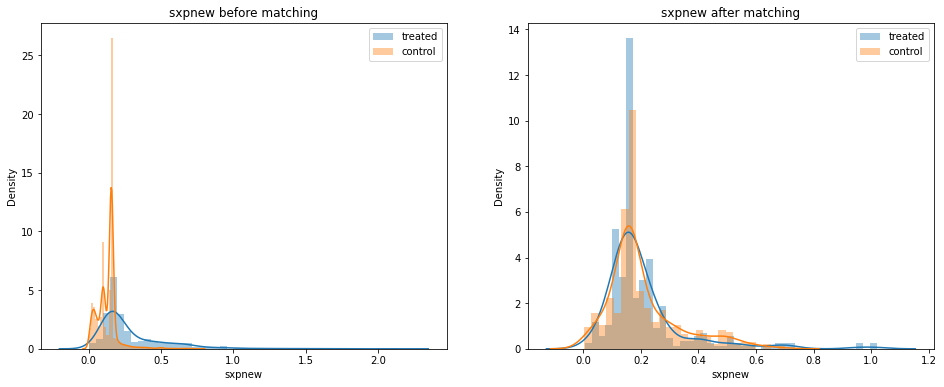

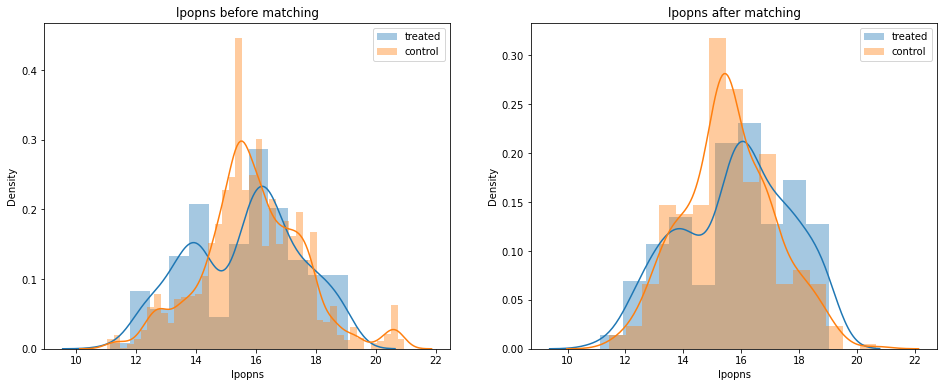

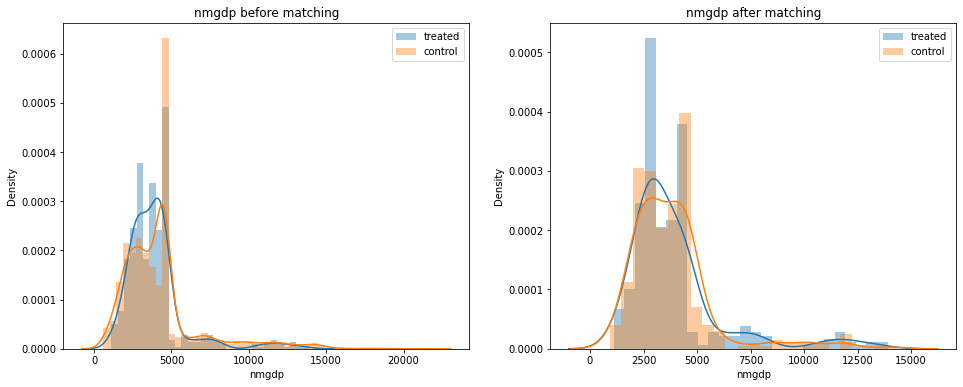

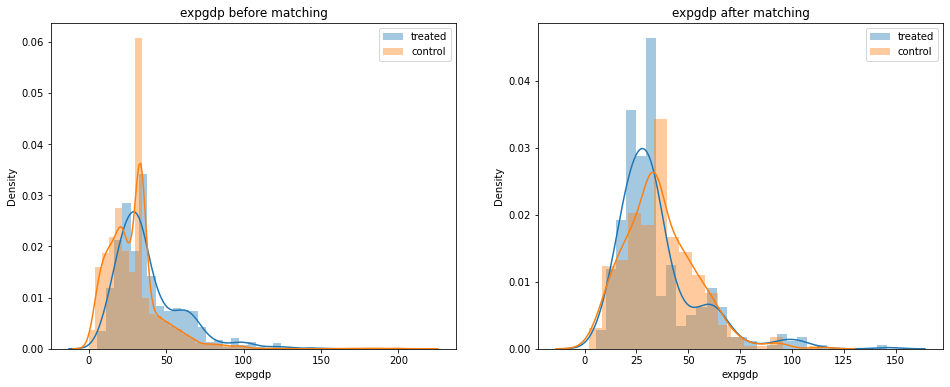

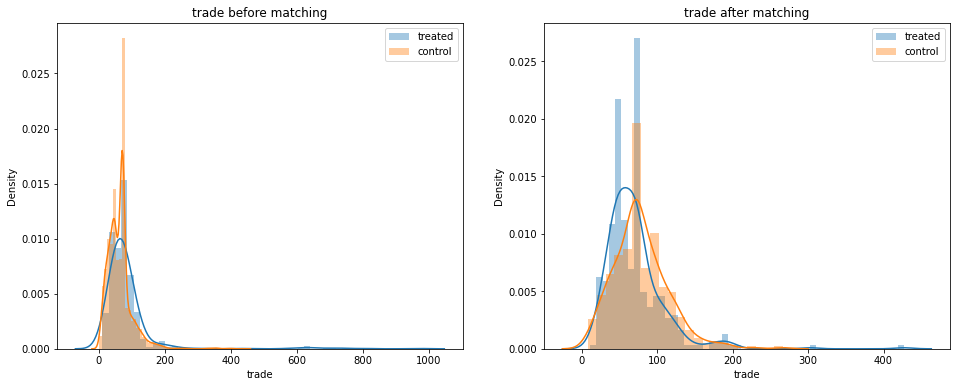

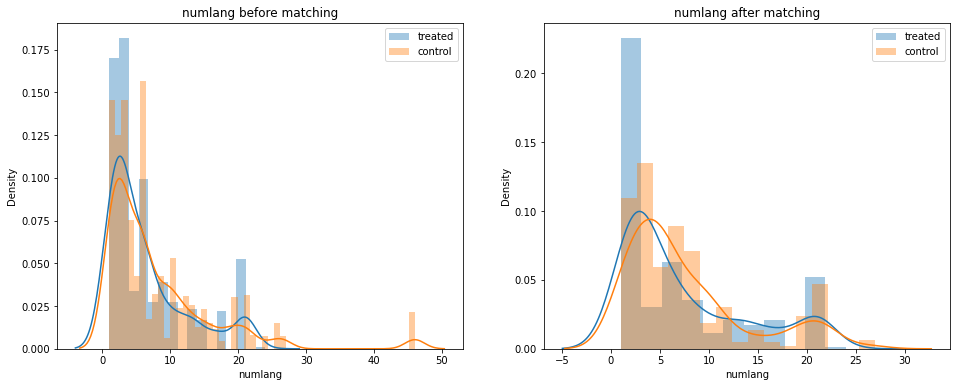

ATE is equal to: 0.178, the 95%-confidence interval is (0.123,0.238)


In [97]:
matching_analysis(df_no_gini_clean, 'oil33', feature_imp_no_gini, feature_names_no_gini, "nogini.pickle")

In [98]:
matching_analysis(df_no_gini_clean, 'oil33', feature_imp_no_gini, feature_names_no_gini, "nogini.pickle", plothists=False, intense_war=True)

Top variables according to mass threshold:  ['sxpnew', 'lpopns', 'nmgdp', 'expgdp', 'trade', 'numlang']
Using formula: oil33 ~ sxpnew + lpopns + nmgdp + expgdp + trade + numlang
Optimization terminated successfully.
         Current function value: 0.231470
         Iterations 8
Loading match:  nogini.pickle
Number of matched elements: 365
ATE is equal to: 0.26, the 95%-confidence interval is (0.181,0.342)


Top variables according to mass threshold:  ['sxpnew', 'lpopns', 'nmgdp', 'expgdp', 'trade', 'numlang']
Using formula: oil ~ sxpnew + lpopns + nmgdp + expgdp + trade + numlang
Optimization terminated successfully.
         Current function value: 0.337801
         Iterations 7
Loading match:  nogini_oil.pickle
Number of matched elements: 778
Plotting!


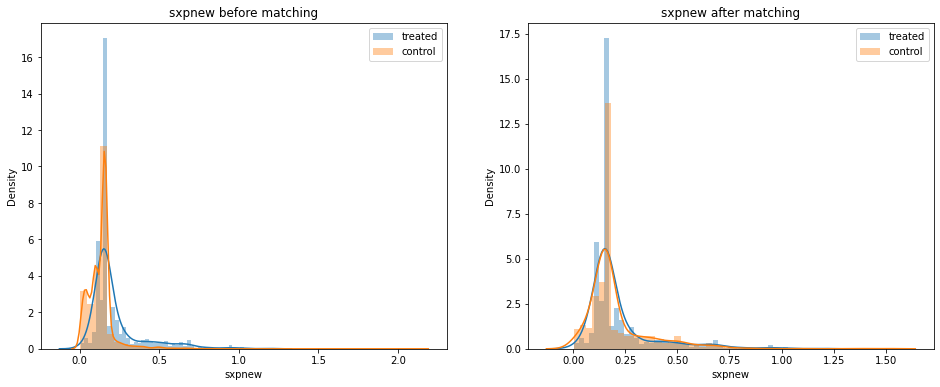

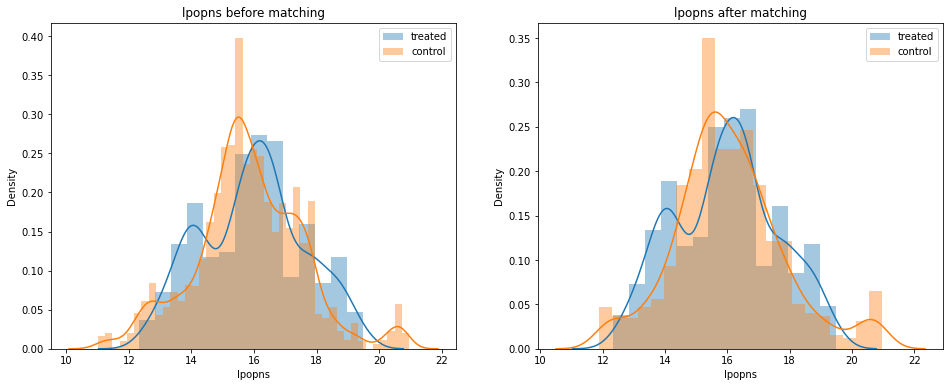

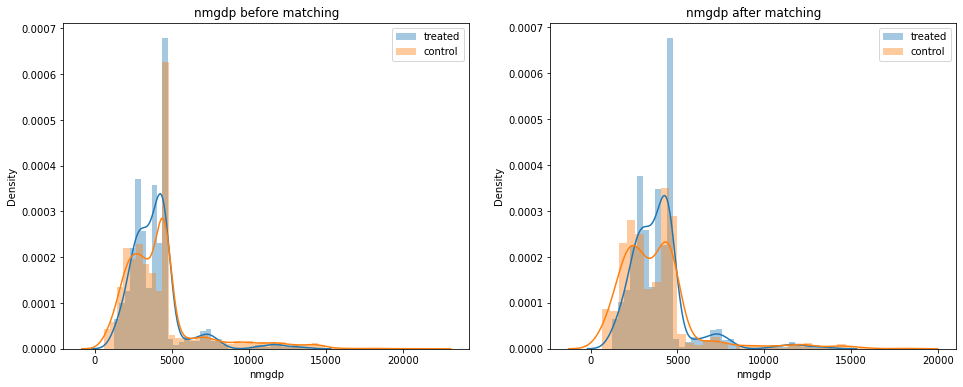

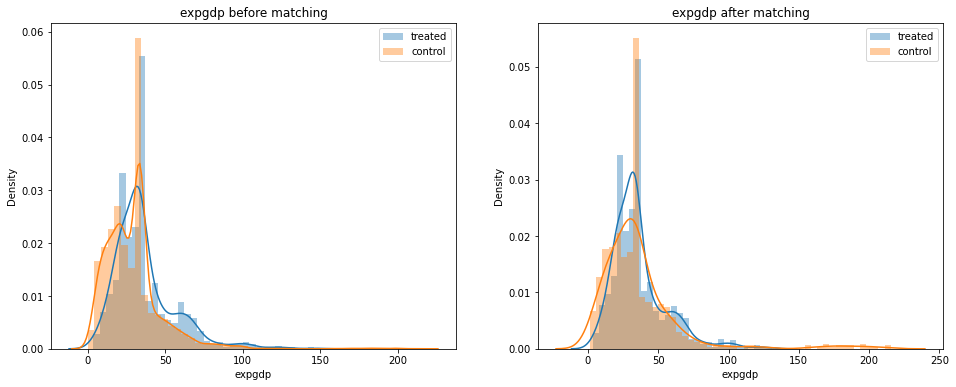

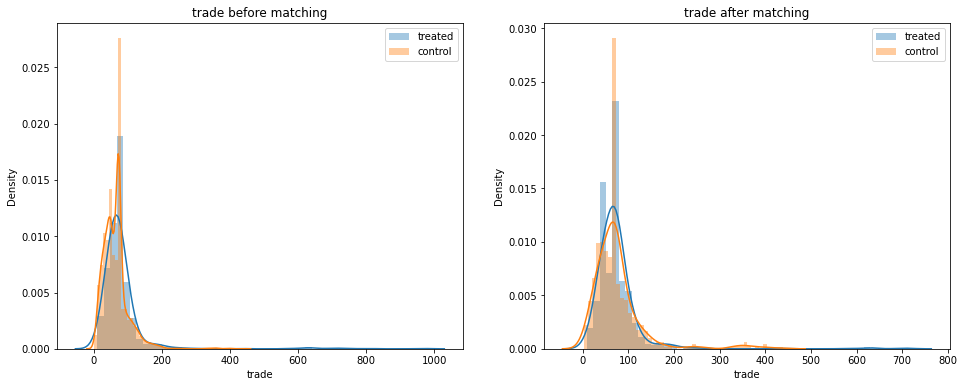

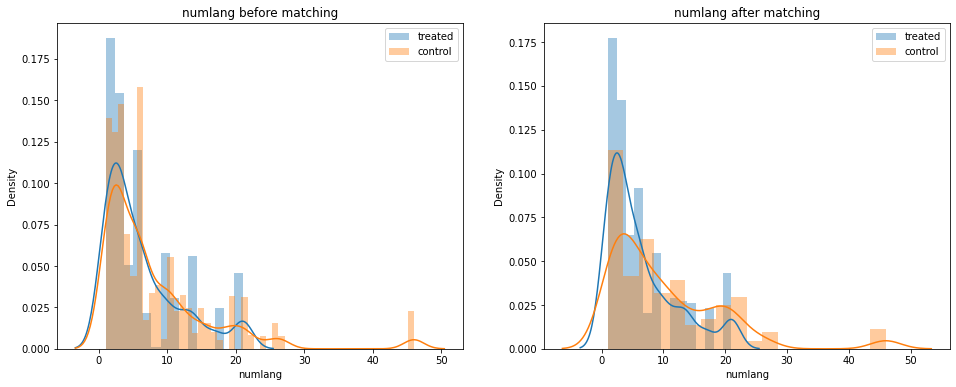

ATE is equal to: 0.0938, the 95%-confidence interval is (0.0514,0.131)


In [99]:
matching_analysis(df_no_gini_clean, 'oil', feature_imp_no_gini, feature_names_no_gini, "nogini_oil.pickle")

In [100]:
matching_analysis(df_no_gini_clean, 'oil', feature_imp_no_gini, feature_names_no_gini, 
                  "nogini_oil.pickle", intense_war=True, plothists=False)

Top variables according to mass threshold:  ['sxpnew', 'lpopns', 'nmgdp', 'expgdp', 'trade', 'numlang']
Using formula: oil ~ sxpnew + lpopns + nmgdp + expgdp + trade + numlang
Optimization terminated successfully.
         Current function value: 0.337801
         Iterations 7
Loading match:  nogini_oil.pickle
Number of matched elements: 778
ATE is equal to: 0.167, the 95%-confidence interval is (0.109,0.229)


Top variables according to mass threshold:  ['illiteracy', 'sxpnew', 'ehet', 'dlang', 'lpopns', 'expgdp']
Using formula: oil33 ~ illiteracy + sxpnew + ehet + dlang + lpopns + expgdp
Optimization terminated successfully.
         Current function value: 0.184800
         Iterations 8
Loading match:  gini.pickle
Number of matched elements: 108
Plotting!


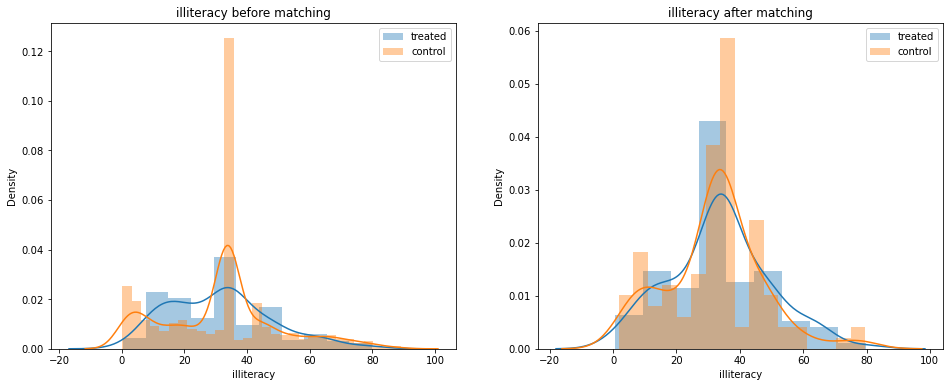

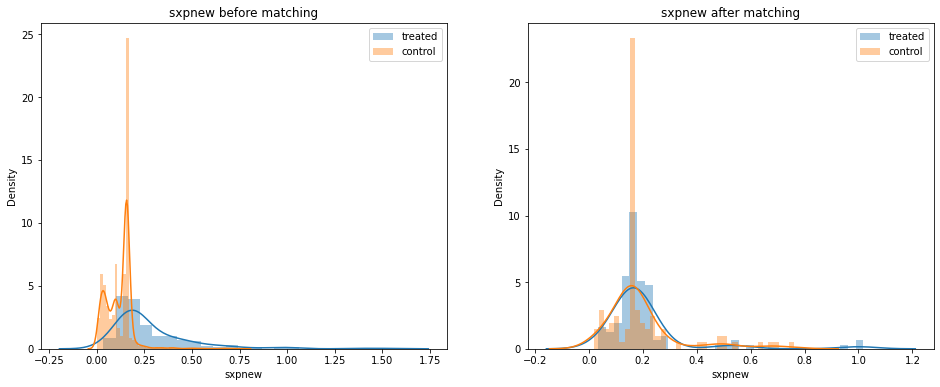

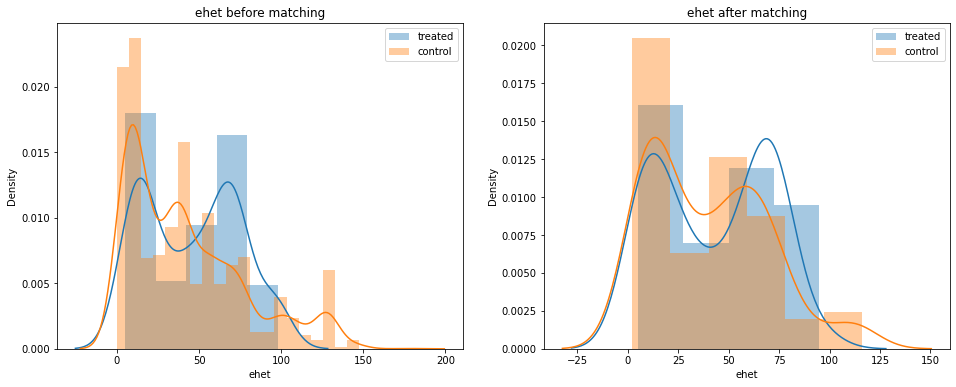

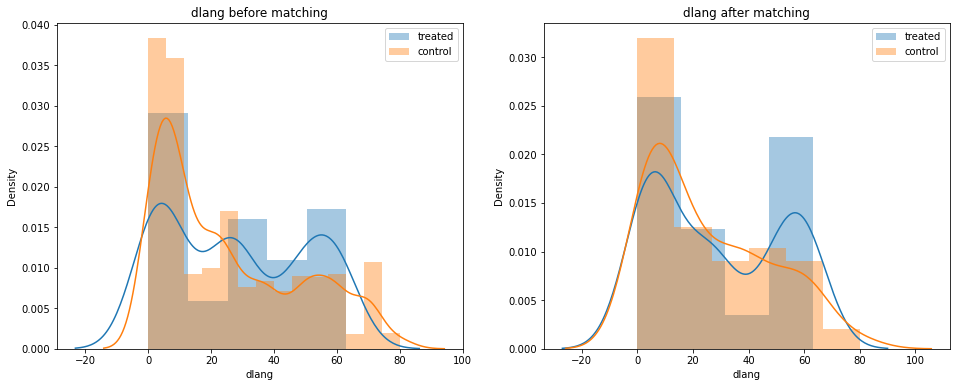

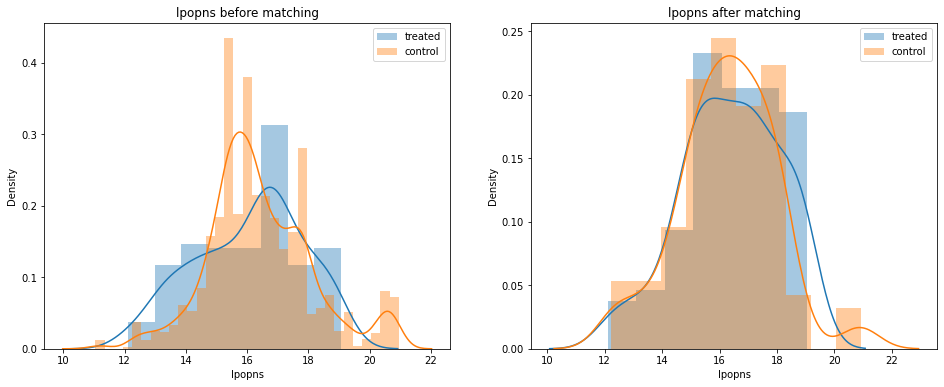

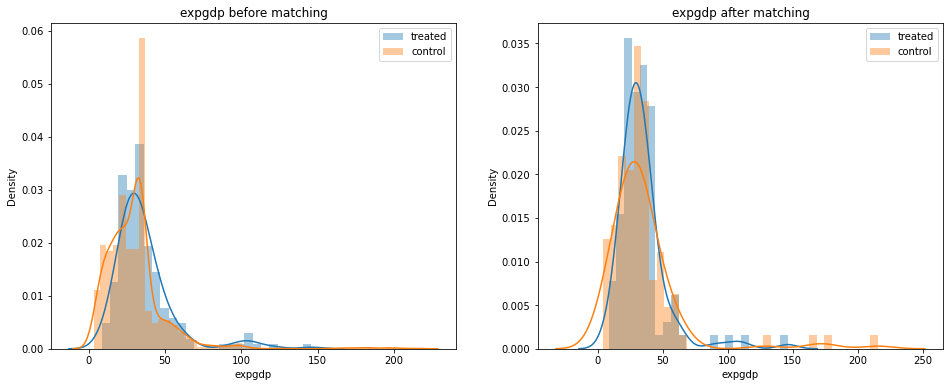

ATE is equal to: 0.157, the 95%-confidence interval is (0.037,0.269)


In [101]:
matching_analysis(df_gini_clean, 'oil33', feature_imp_gini, feature_names_gini, 
                  "gini.pickle")

In [102]:
matching_analysis(df_gini_clean, 'oil33', feature_imp_gini, feature_names_gini, 
                  "gini.pickle", plothists=False, intense_war=True)

Top variables according to mass threshold:  ['illiteracy', 'sxpnew', 'ehet', 'dlang', 'lpopns', 'expgdp']
Using formula: oil33 ~ illiteracy + sxpnew + ehet + dlang + lpopns + expgdp
Optimization terminated successfully.
         Current function value: 0.184800
         Iterations 8
Loading match:  gini.pickle
Number of matched elements: 108
ATE is equal to: 0.213, the 95%-confidence interval is (0.0741,0.361)


Top variables according to mass threshold:  ['illiteracy', 'sxpnew', 'ehet', 'dlang', 'lpopns', 'expgdp']
Using formula: oil ~ illiteracy + sxpnew + ehet + dlang + lpopns + expgdp
Optimization terminated successfully.
         Current function value: 0.328825
         Iterations 7
Loading match:  gini_oil.pickle
Number of matched elements: 302
Plotting!


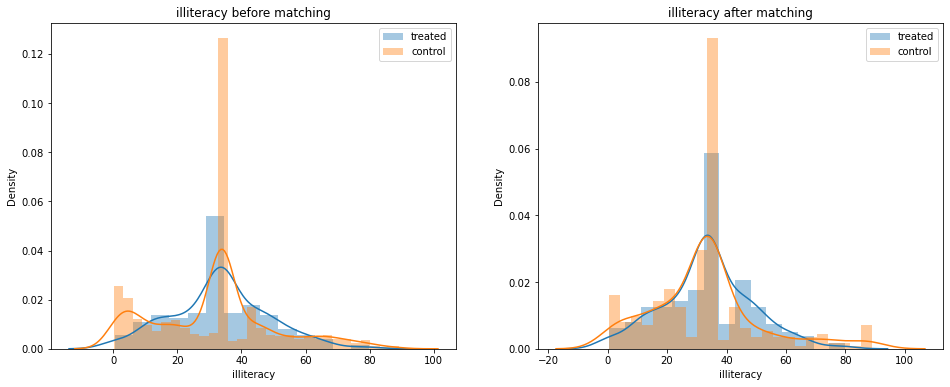

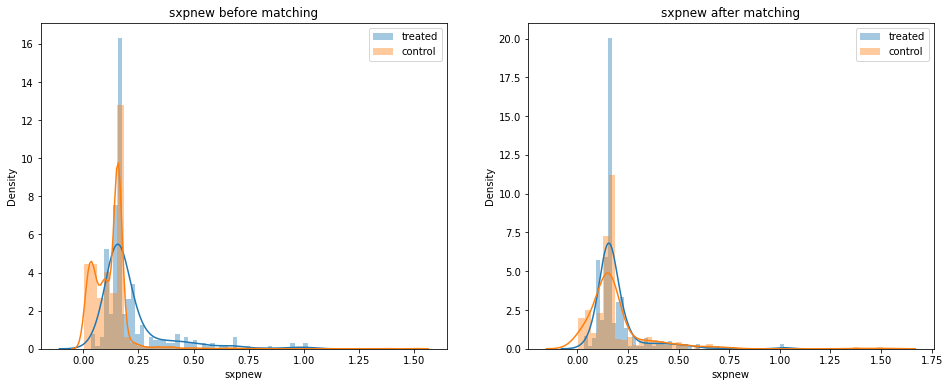

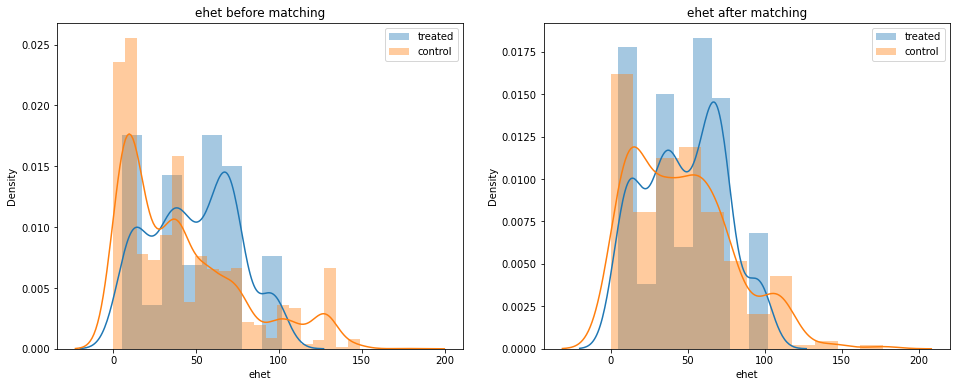

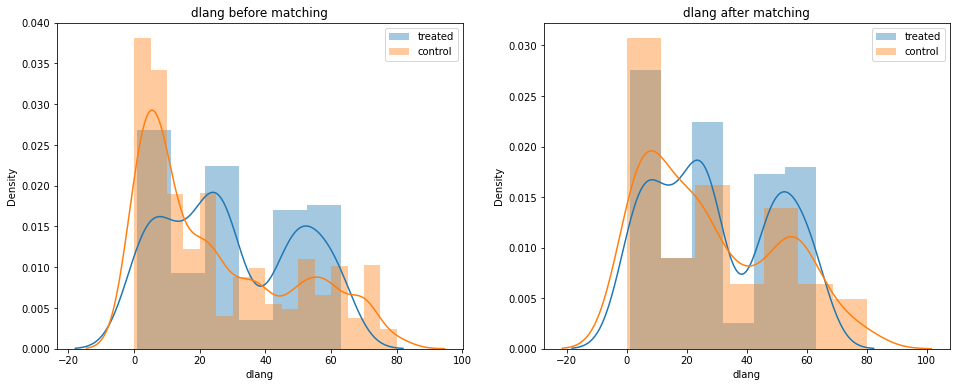

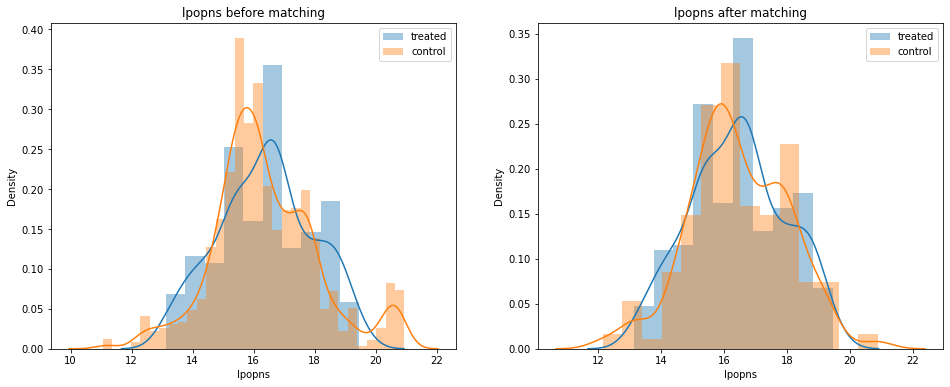

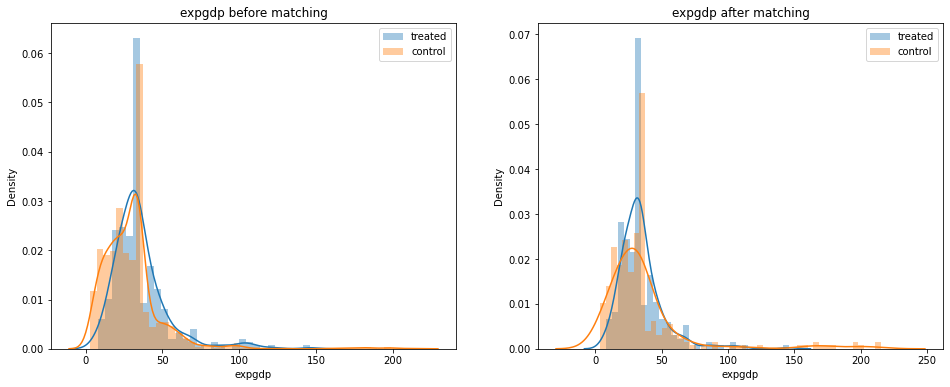

ATE is equal to: 0.185, the 95%-confidence interval is (0.116,0.252)


In [103]:
matching_analysis(df_gini_clean, 'oil', feature_imp_gini, feature_names_gini, 
                  "gini_oil.pickle")

In [104]:
matching_analysis(df_gini_clean, 'oil', feature_imp_gini, feature_names_gini, 
                  "gini_oil.pickle", plothists=False, intense_war=True)

Top variables according to mass threshold:  ['illiteracy', 'sxpnew', 'ehet', 'dlang', 'lpopns', 'expgdp']
Using formula: oil ~ illiteracy + sxpnew + ehet + dlang + lpopns + expgdp
Optimization terminated successfully.
         Current function value: 0.328825
         Iterations 7
Loading match:  gini_oil.pickle
Number of matched elements: 302
ATE is equal to: 0.258, the 95%-confidence interval is (0.162,0.358)


In [132]:
df_no_gini[df_no_gini["oil"] == 1].country.unique()

array(['Algeria', 'Angola', 'Azerbaijan', 'Bahrain', 'Bolivia',
       'Cameroon', 'Colombia', 'Congo (Braz)', 'Ecuador', 'Egypt',
       'Gabon', 'Indonesia', 'Iran', 'Iraq', 'Kazakhstan', 'Kuwait',
       'Libya', 'Mexico', 'Nigeria', 'Norway', 'Oman', 'Panama',
       'Saudi Arabia', 'Senegal', 'Singapore', 'Syria',
       'Trinidad and Tobago', 'Tunisia', 'Turkmenistan',
       'Russia (Soviet Union)', 'Russia', 'U.A.R.', 'Venezuela', 'Yemen'],
      dtype=object)

In [133]:
df_gini[df_gini["oil"] == 1].country.unique()

array(['Algeria', 'Angola', 'Azerbaijan', 'Bahrain', 'Bolivia',
       'Cameroon', 'Colombia', 'Congo (Braz)', 'Ecuador', 'Egypt',
       'Gabon', 'Indonesia', 'Iran', 'Iraq', 'Kazakhstan', 'Kuwait',
       'Libya', 'Mexico', 'Nigeria', 'Norway', 'Oman', 'Panama',
       'Saudi Arabia', 'Senegal', 'Singapore', 'Syria',
       'Trinidad and Tobago', 'Tunisia', 'Turkmenistan',
       'Russia (Soviet Union)', 'Russia', 'U.A.R.', 'Venezuela', 'Yemen'],
      dtype=object)

In [139]:
#!conda install -y geopandas descartes

^C

CondaError: KeyboardInterrupt



# World Maps

In [177]:
gpd_rename = {
    "Bosnia and Herz" : 'Bosnia-Herzegovina',
    'Central African Rep.' : 'C.A.R.',
    'Congo' : 'Congo (Braz)',
    'Czechia' : 'Czech Republic',
    'Côte d\'Ivoire' : 'Ivory Coast',
    'Dem. Rep. Congo' : 'DR Congo (Zaire)',
    'Dominican Rep.' : 'Dominican Republic',
    'Myanmar' : 'Myanmar (Burma)',
    'South Korea' : 'Korea, South',
    'United Arab Emirates' : 'U.A.R.',
    'United Kingdom' : 'U.K.',
    'United States of America' : 'U.S.A.'    
}

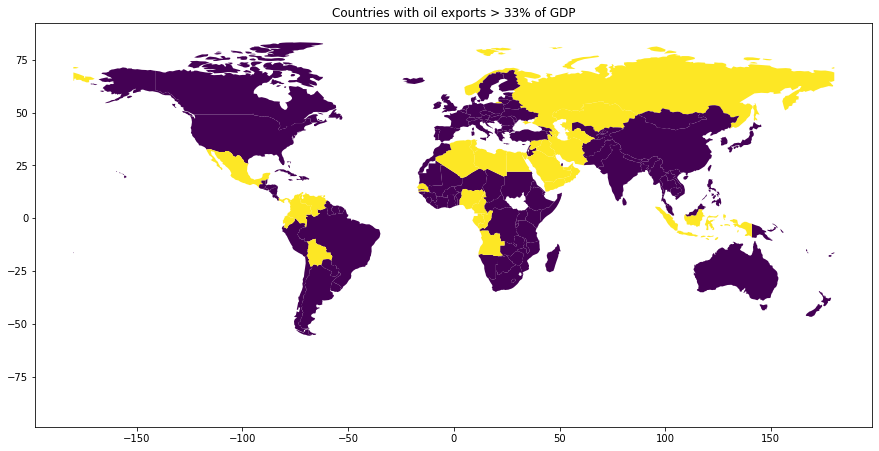

In [247]:
import geopandas
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world.name = [gpd_rename.get(x, x) for x in world.name]

oil = joined[["country", "year", "oil"]].groupby("country").max()
world_merged = world.merge(oil[["oil"]], how="left", left_on="name", right_index=True)
world_merged.plot(column="oil", figsize=(15,10)).set_title("Countries with oil exports > 33% of GDP")
plt.savefig("img/oil_country_map")
plt.show()

# Map of all countries that ever had oil == 1

In [209]:
# Used for renaming

In [167]:
np.setdiff1d(world["name"].unique(), joined.country.unique())

array(['Antarctica', 'Bosnia and Herz.', 'Central African Rep.', 'Congo',
       'Czechia', "Côte d'Ivoire", 'Dem. Rep. Congo', 'Dominican Rep.',
       'Eq. Guinea', 'Falkland Is.', 'Fr. S. Antarctic Lands',
       'Greenland', 'Kosovo', 'Montenegro', 'Myanmar', 'N. Cyprus',
       'New Caledonia', 'North Korea', 'Palestine', 'Puerto Rico',
       'S. Sudan', 'Serbia', 'Solomon Is.', 'Somaliland', 'South Korea',
       'Timor-Leste', 'United Arab Emirates', 'United Kingdom',
       'United States of America', 'W. Sahara', 'eSwatini'], dtype=object)

In [168]:
np.setdiff1d(joined.country.unique(), world["name"].unique())

array(['Bahrain', 'Barbados', 'Bosnia-Herzegovina', 'C.A.R.',
       'Cape Verde', 'Comoros', 'Congo (Braz)', 'Czech Republic',
       'Czechoslovakia', 'DR Congo (Zaire)', 'Dominican Republic',
       'Grenada', 'Ivory Coast', 'Korea, South', 'Malta', 'Mauritius',
       'Myanmar (Burma)', 'Russia (Soviet Union)', 'Seychelles',
       'Singapore', 'Solomon Islands', 'South Vietnam', 'Swaziland',
       'U.A.R.', 'U.K.', 'U.S.A.', 'Western Samoa', 'Yemen AR',
       'Yemen PR', 'Yugoslavia'], dtype=object)

In [212]:
war = joined[["country", "year", "war"]]
war_map = world.merge(war, how="left", left_on="name", right_on="country")

Year: 1970
Year: 1971
Year: 1972
Year: 1973
Year: 1974
Year: 1975
Year: 1976
Year: 1977
Year: 1978
Year: 1979
Year: 1980
Year: 1981
Year: 1982
Year: 1983
Year: 1984
Year: 1985
Year: 1986
Year: 1987
Year: 1988
Year: 1989
Year: 1990
Year: 1991
Year: 1992
Year: 1993
Year: 1994
Year: 1995
Year: 1996
Year: 1997
Year: 1998
Year: 1999
Year: 2000
Year: 1961
Year: 1962
Year: 1963
Year: 1964
Year: 1965
Year: 1966
Year: 1967
Year: 1968
Year: 1969
Year: -9223372036854775808
Year: 1945
Year: 1946
Year: 1947
Year: 1948
Year: 1949
Year: 1950
Year: 1951
Year: 1952
Year: 1953
Year: 1954
Year: 1955
Year: 1956
Year: 1957
Year: 1958
Year: 1959
Year: 1960


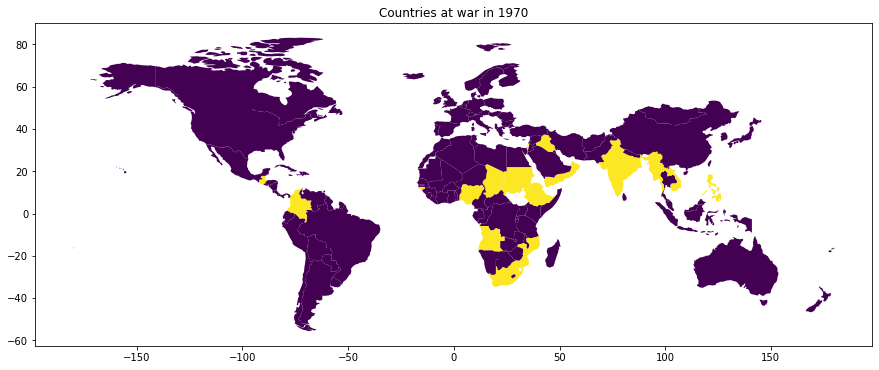

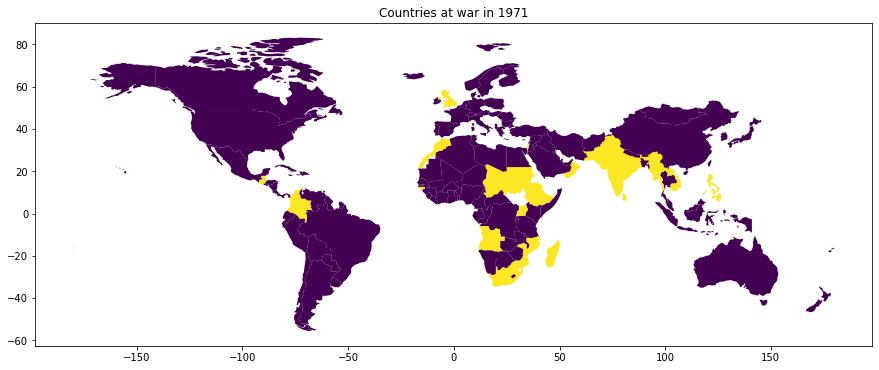

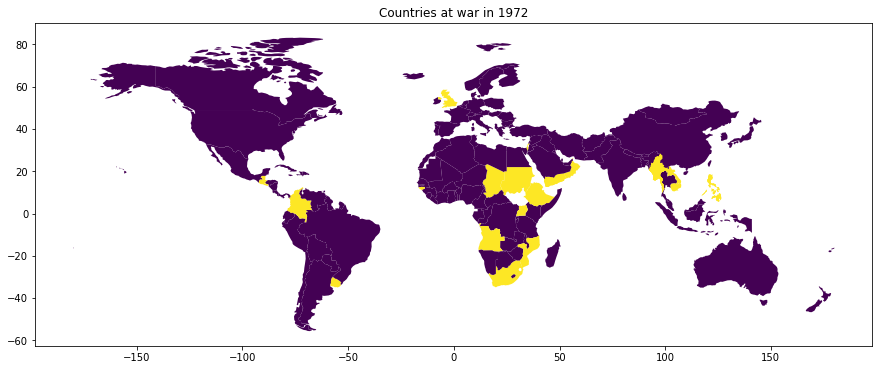

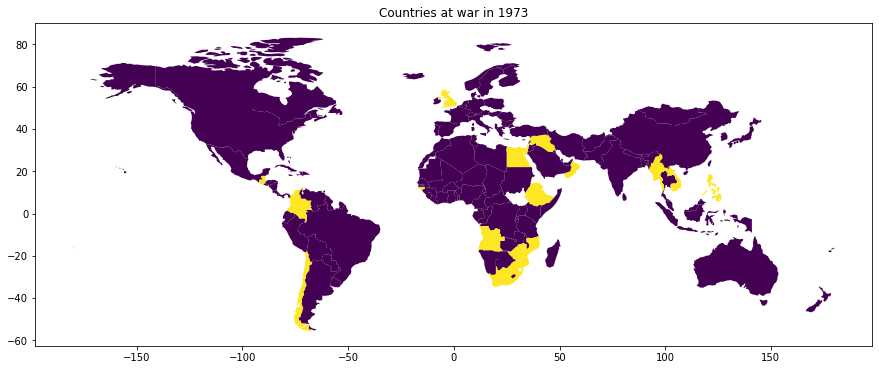

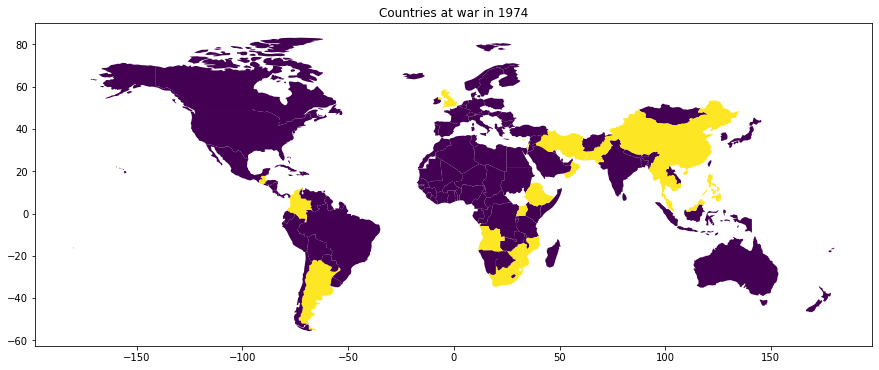

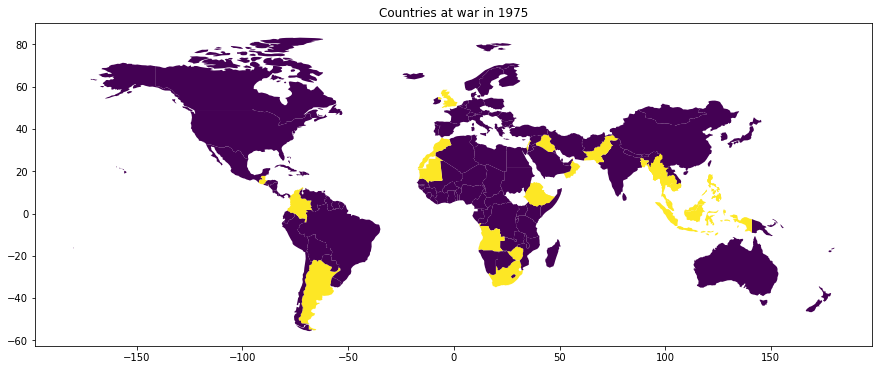

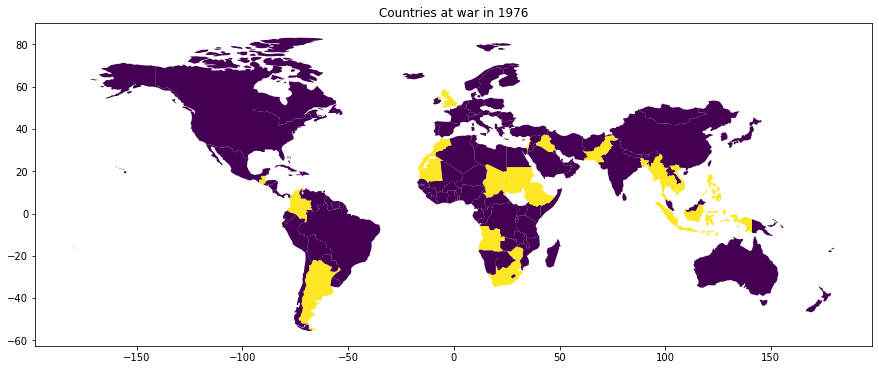

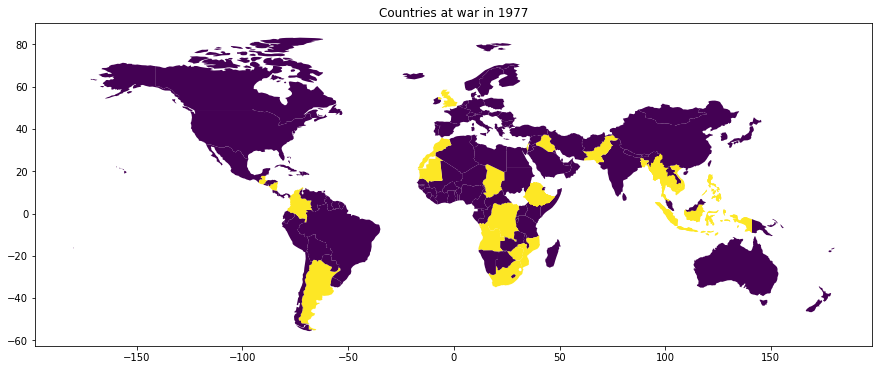

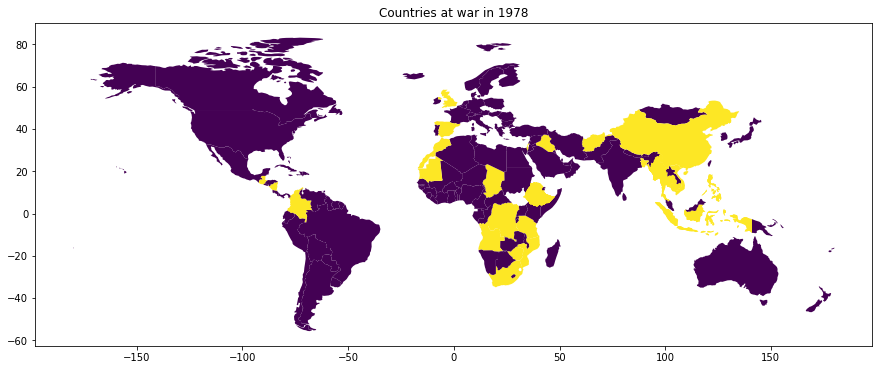

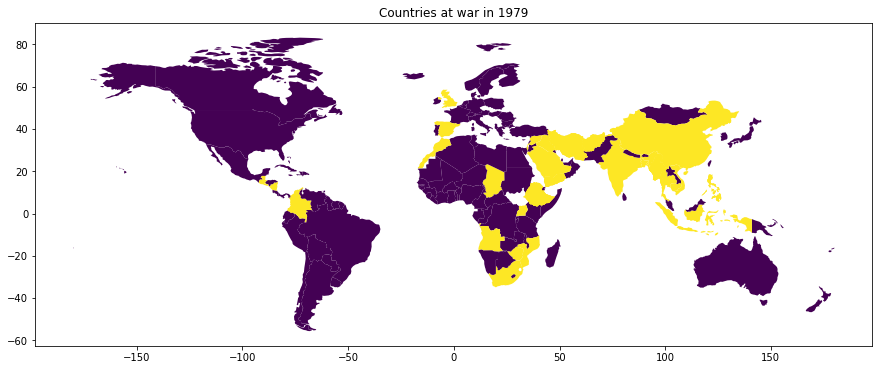

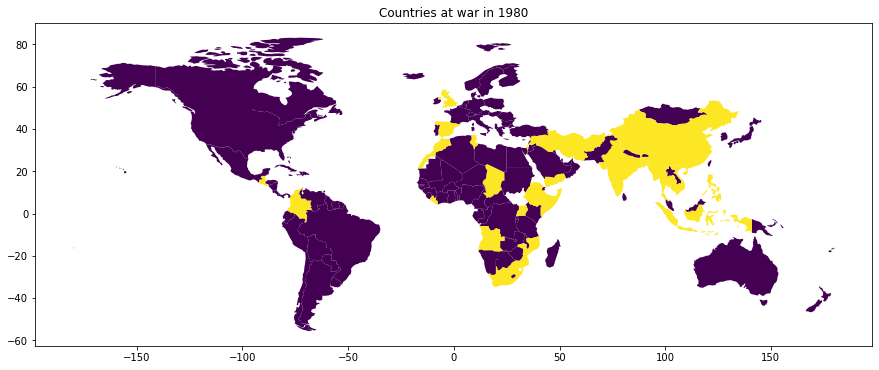

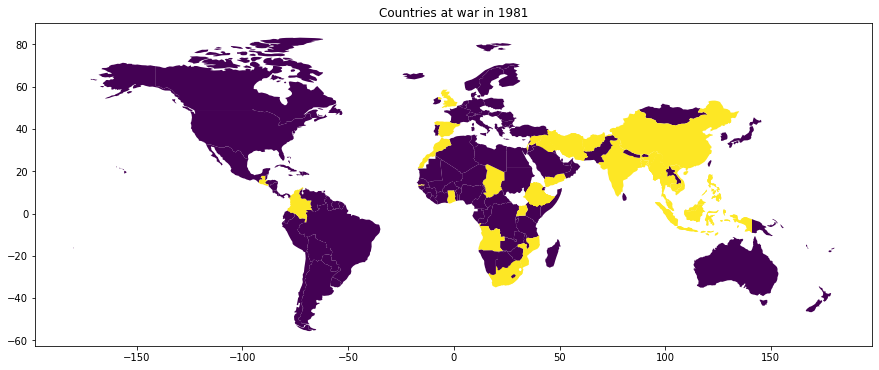

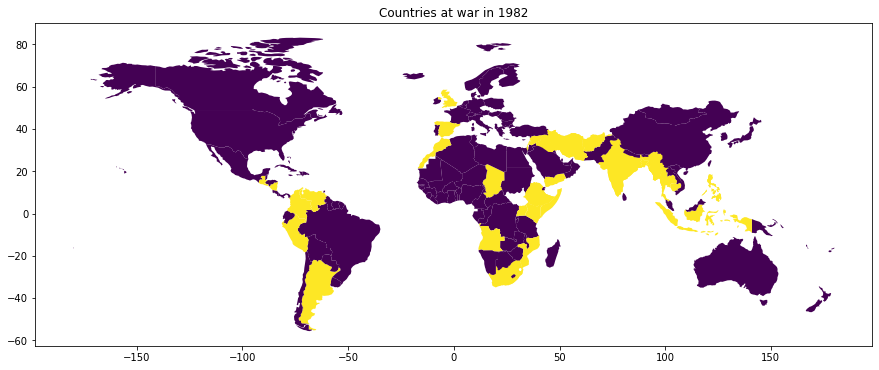

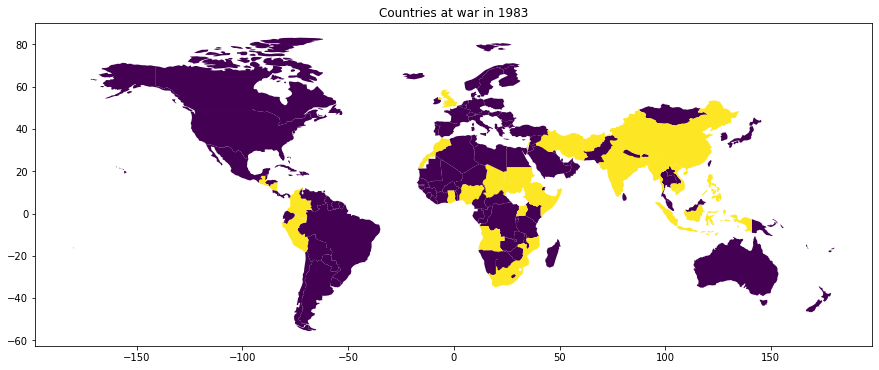

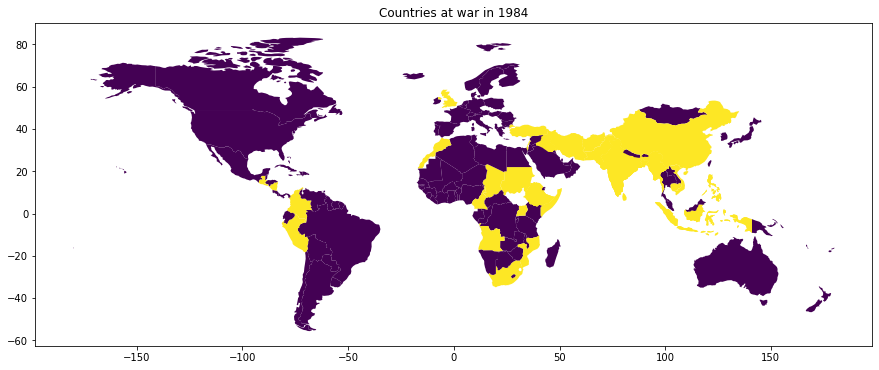

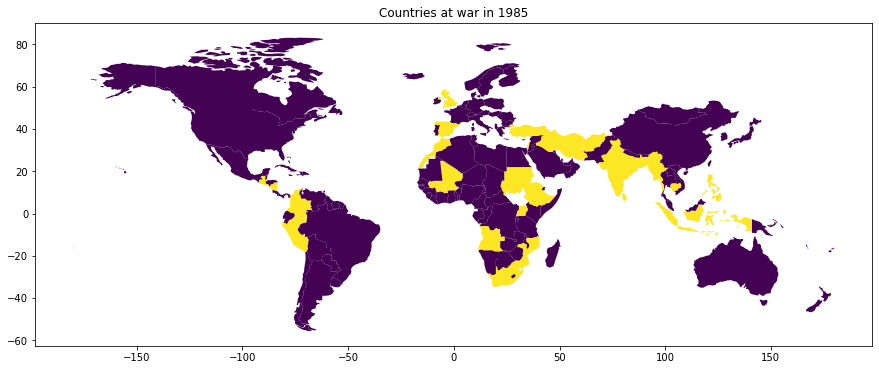

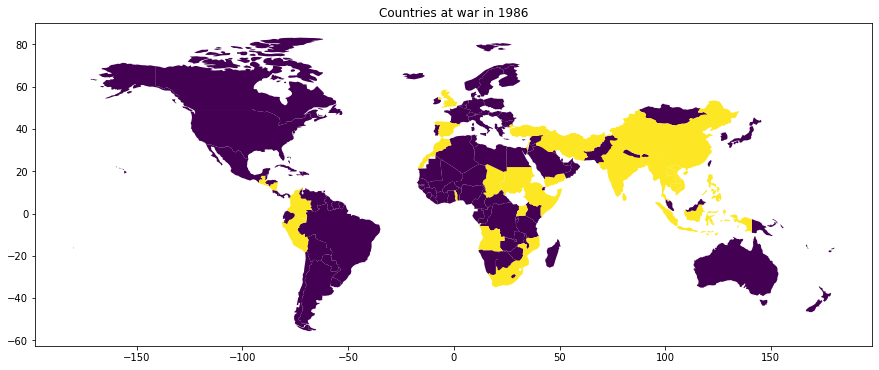

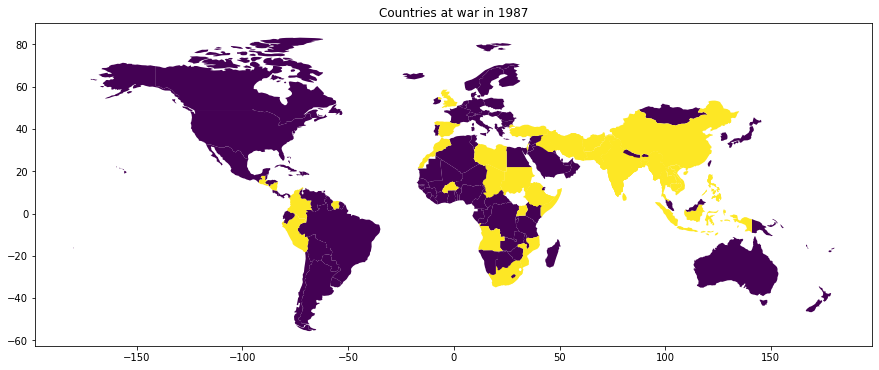

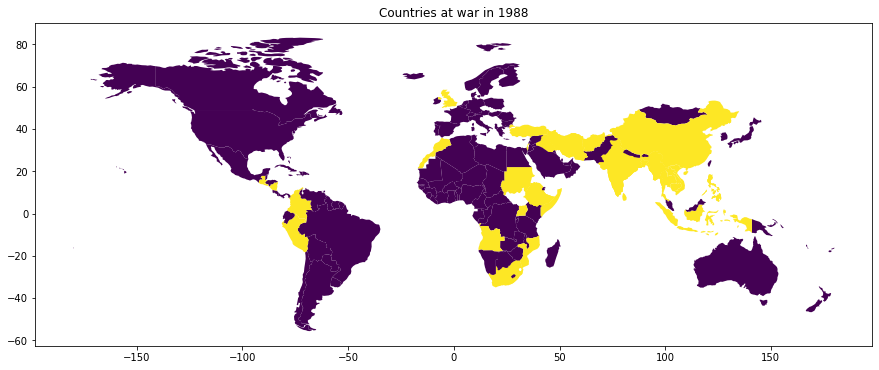

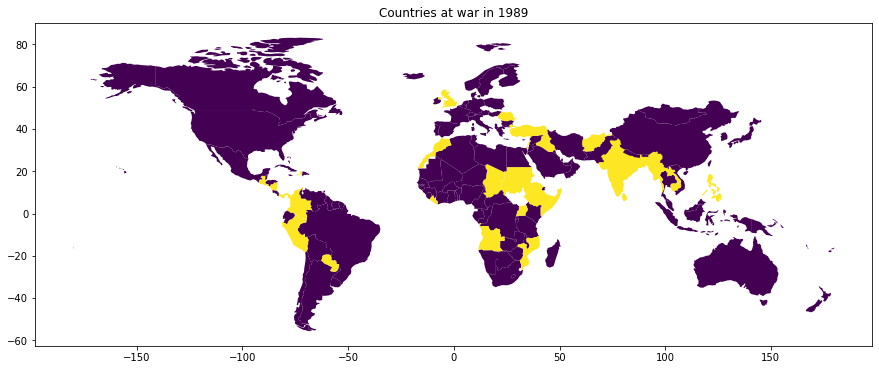

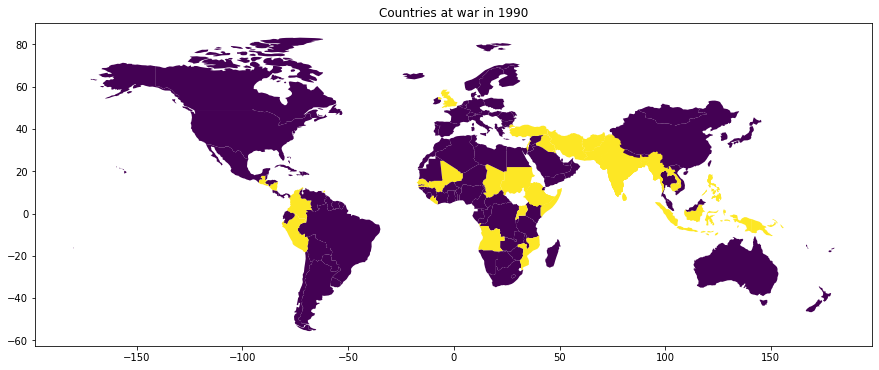

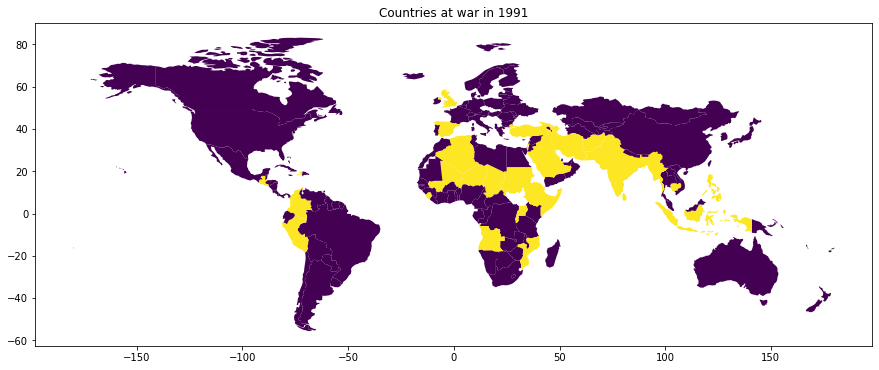

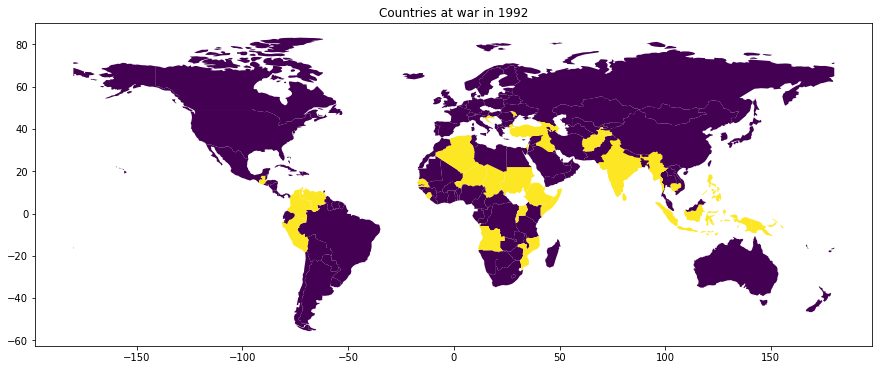

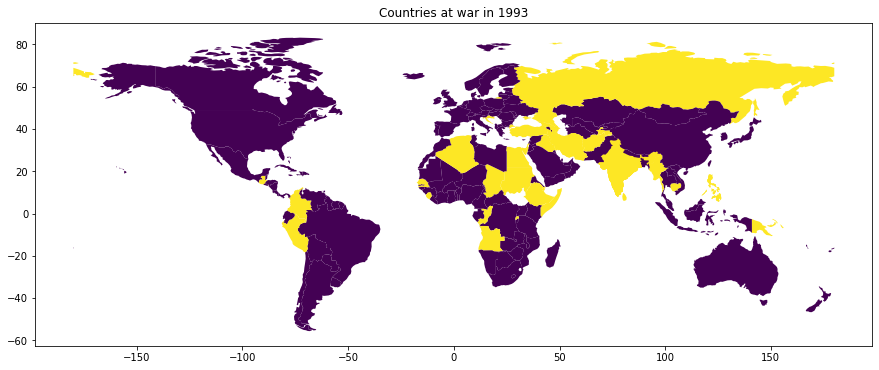

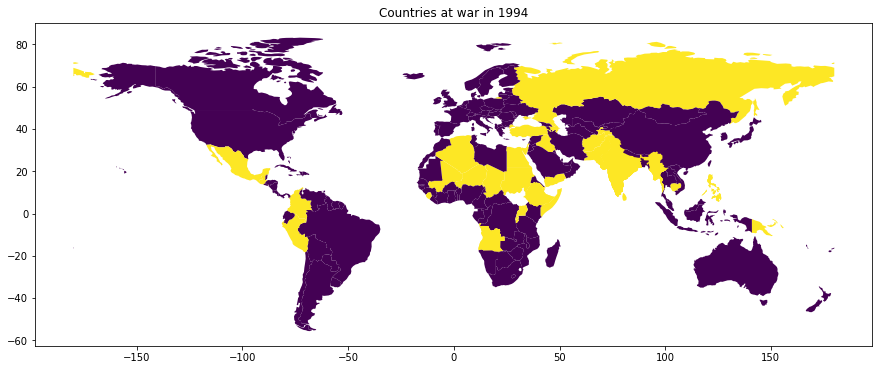

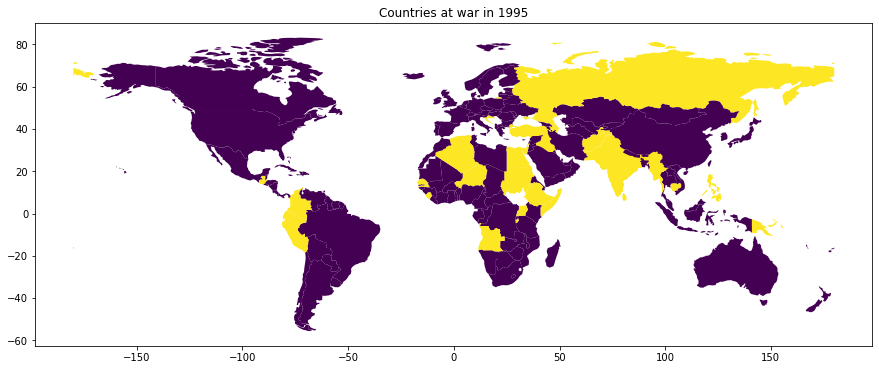

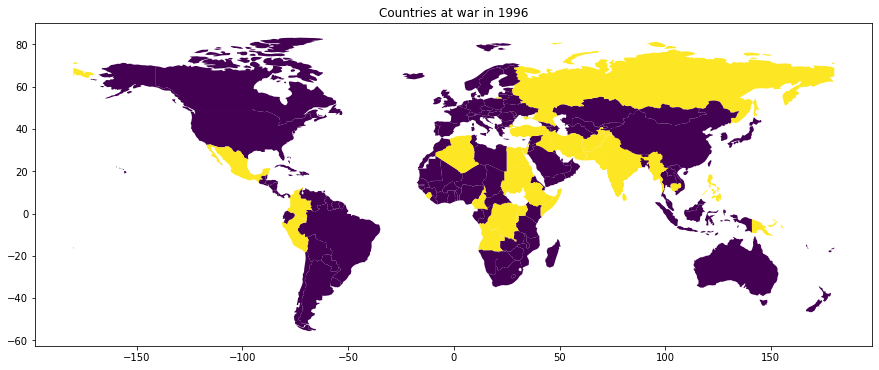

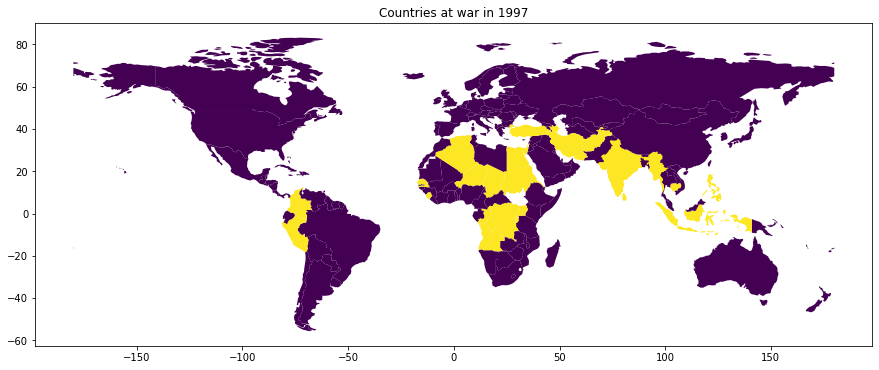

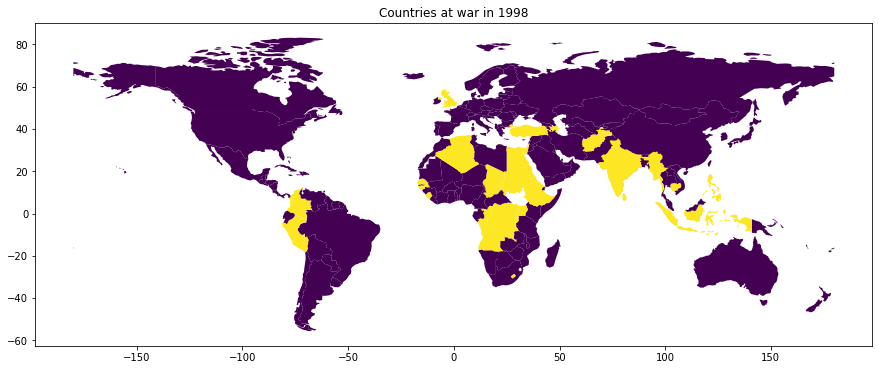

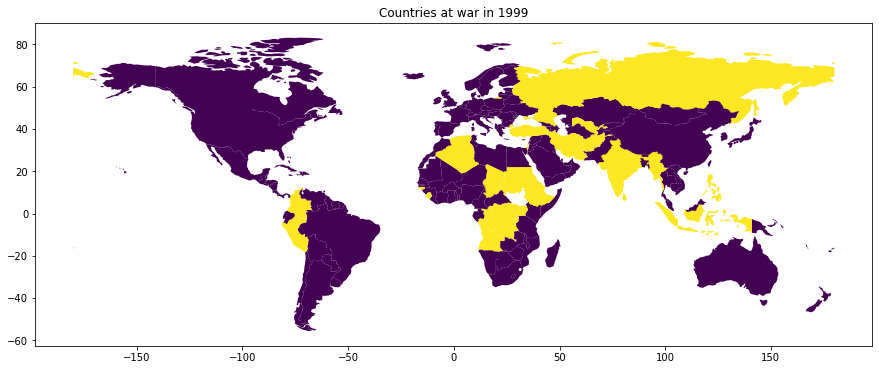

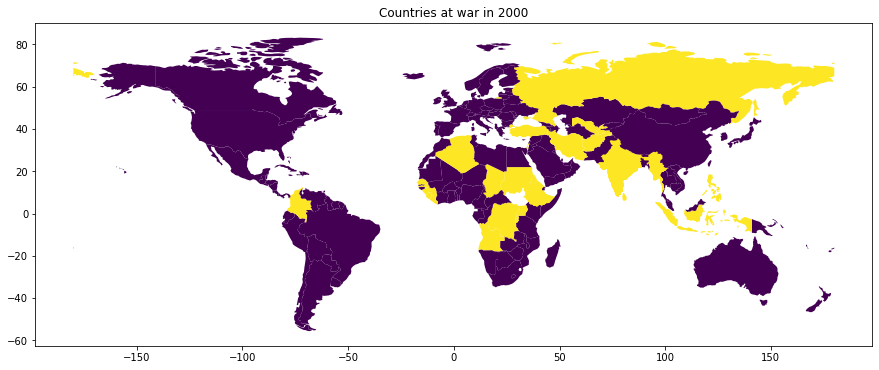

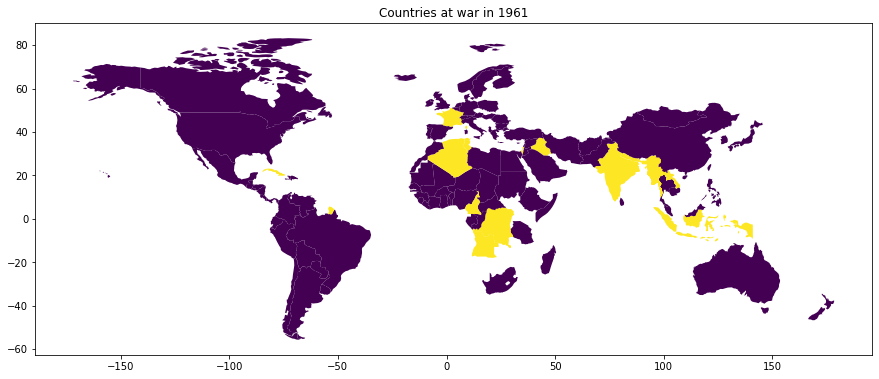

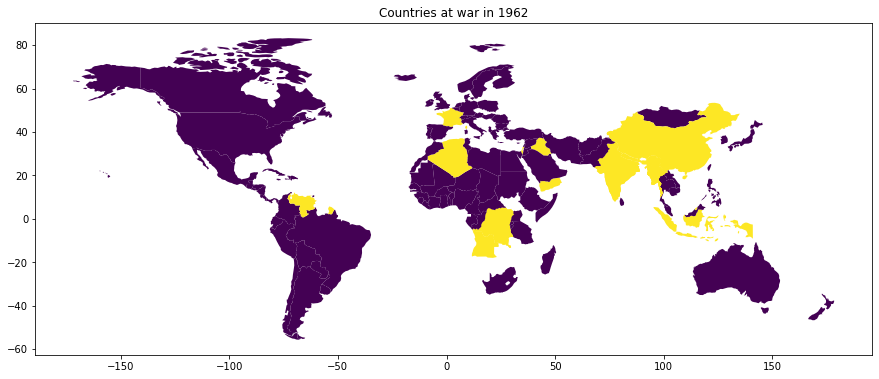

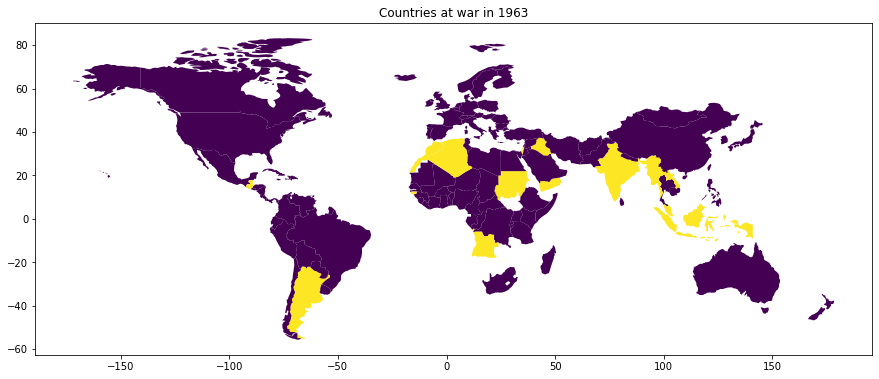

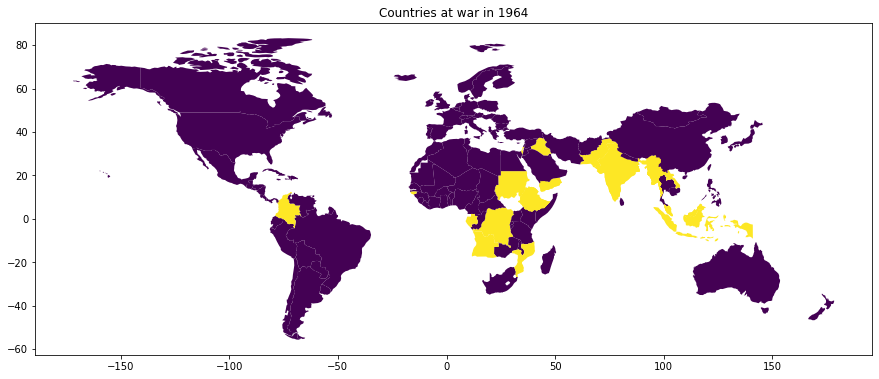

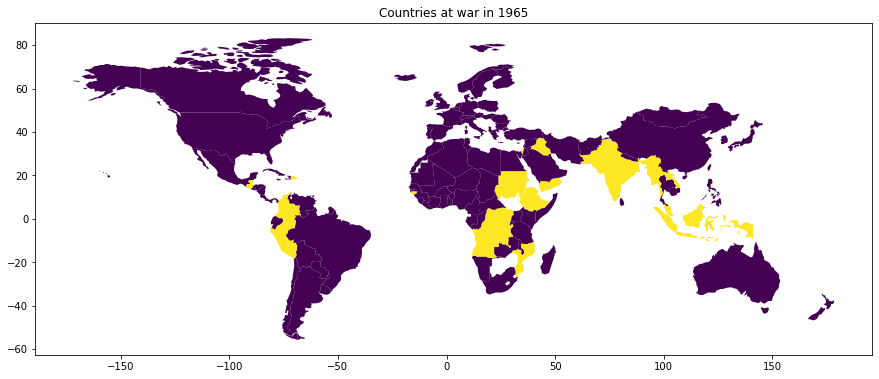

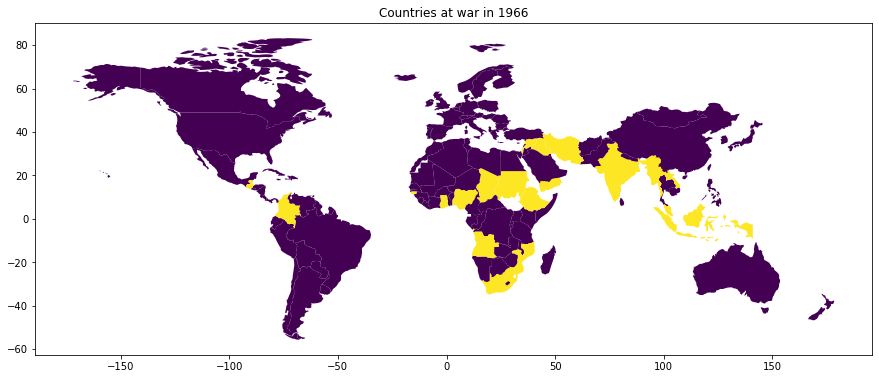

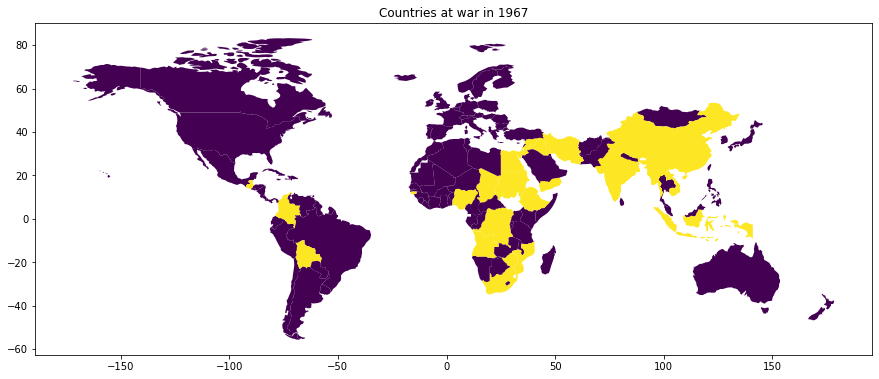

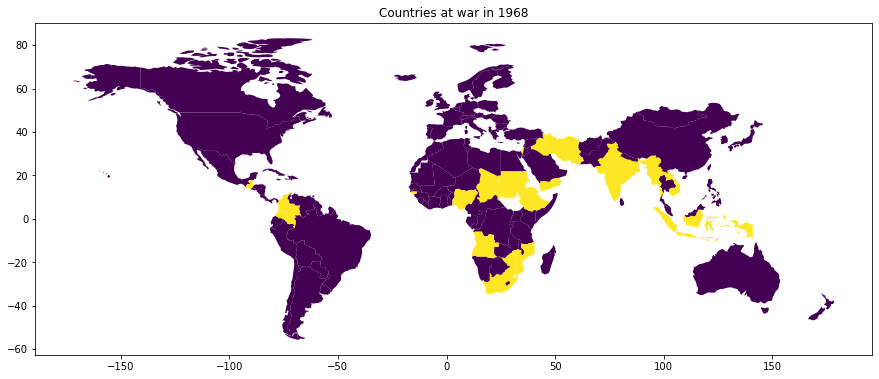

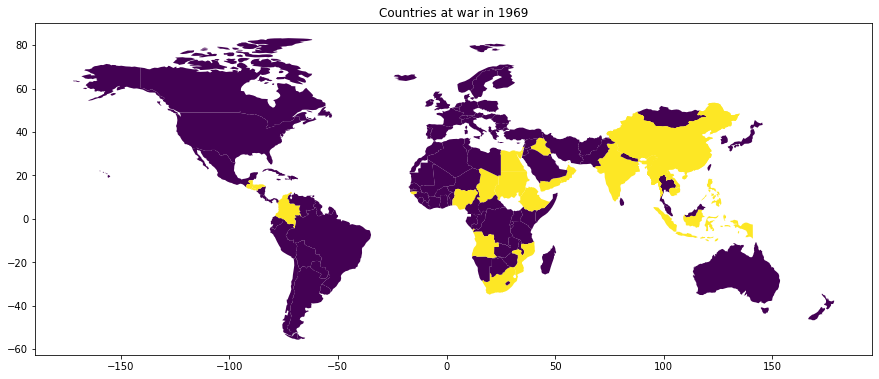

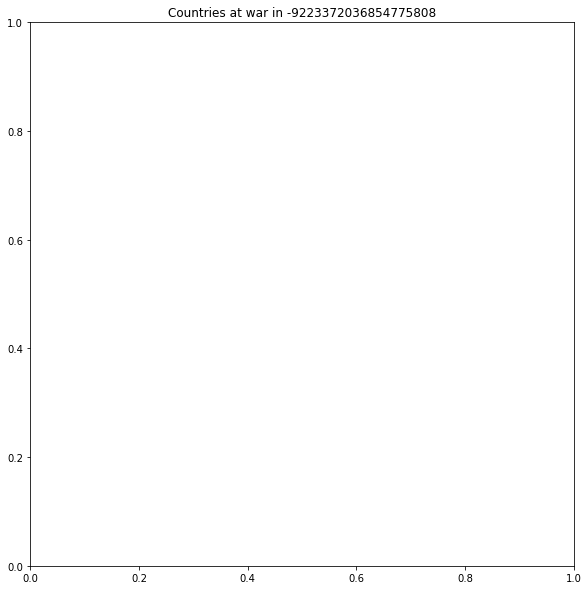

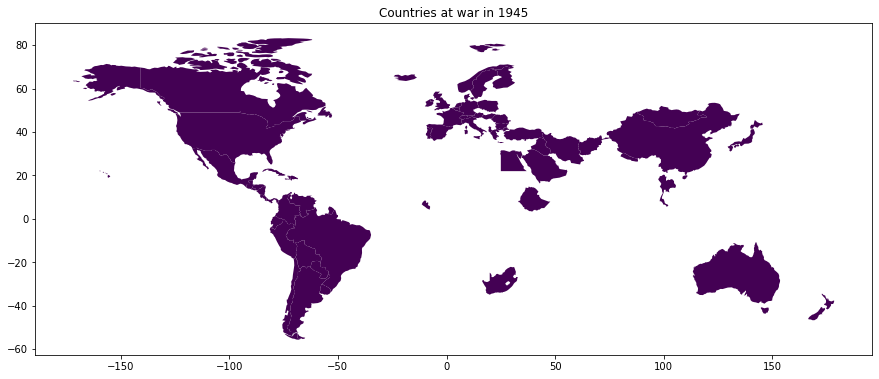

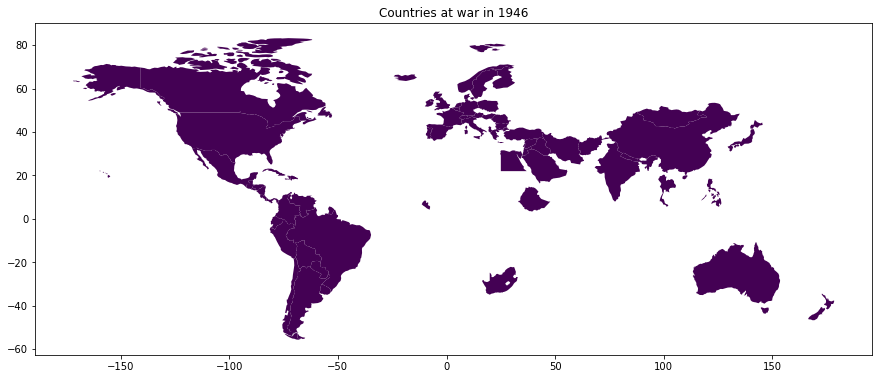

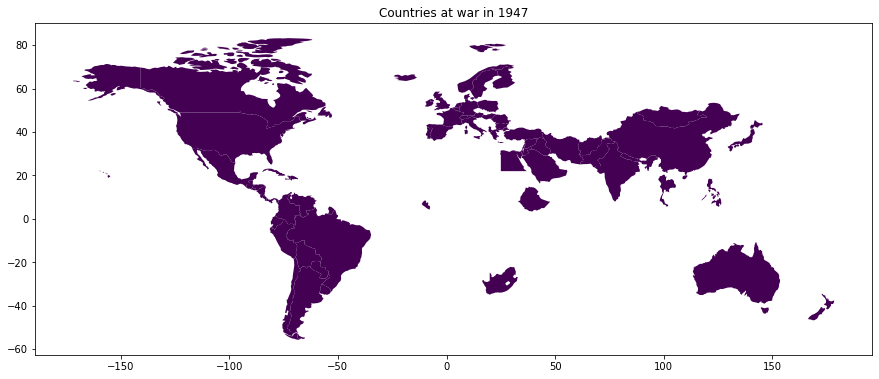

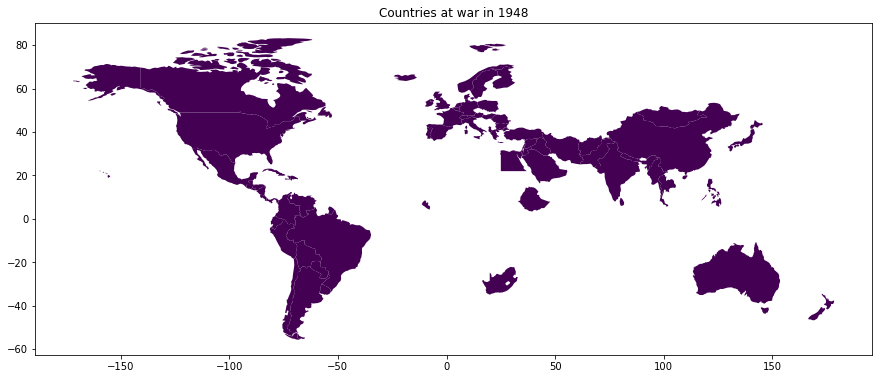

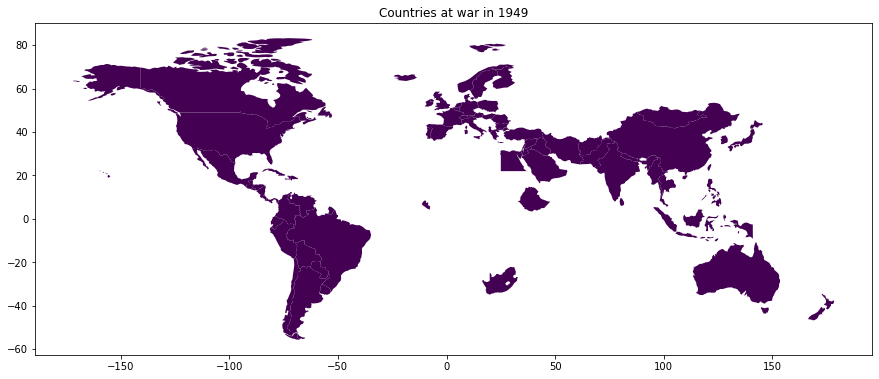

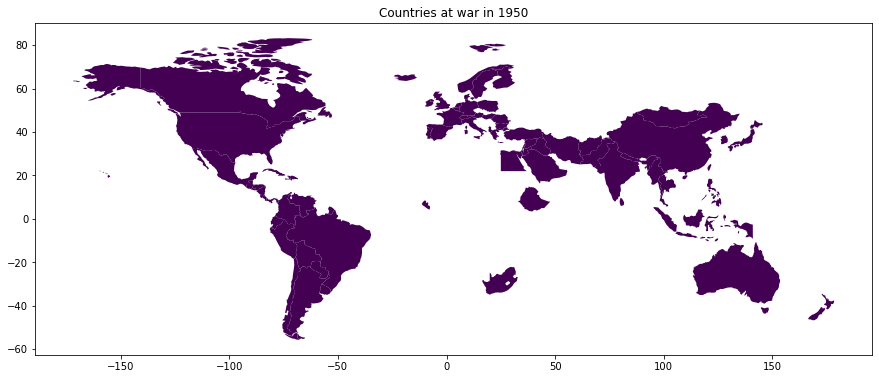

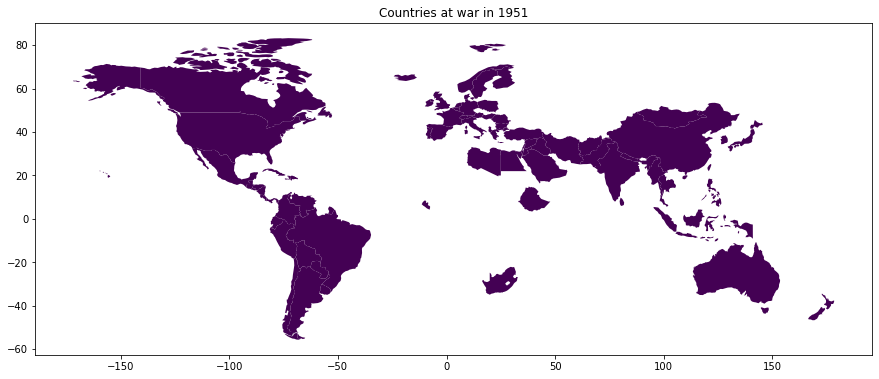

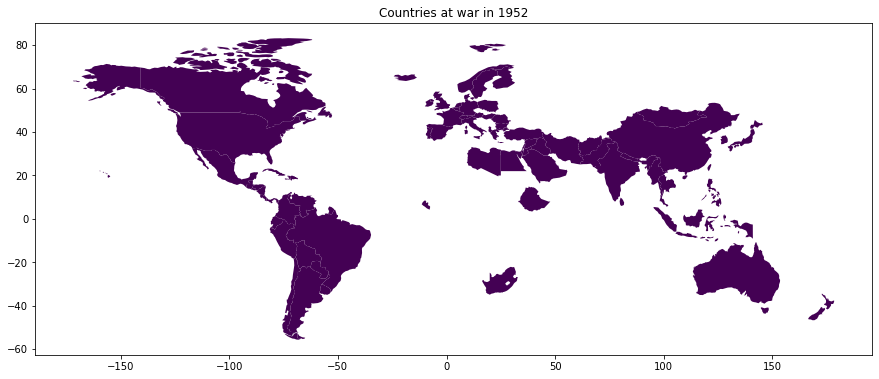

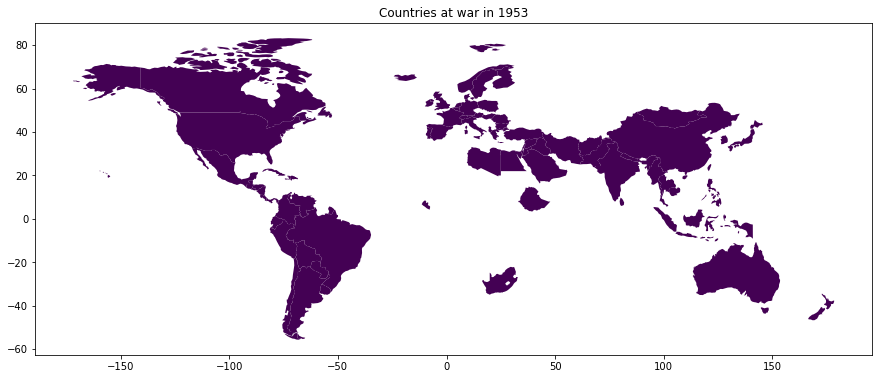

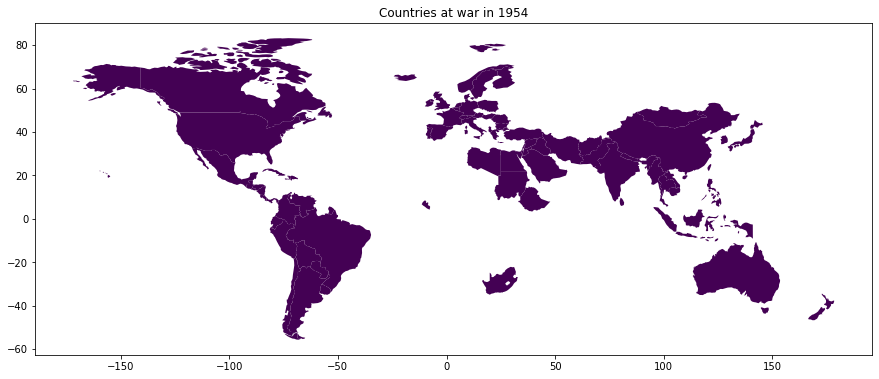

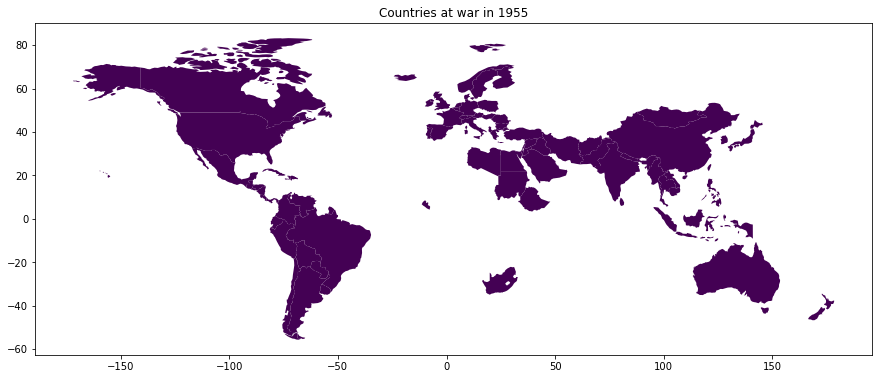

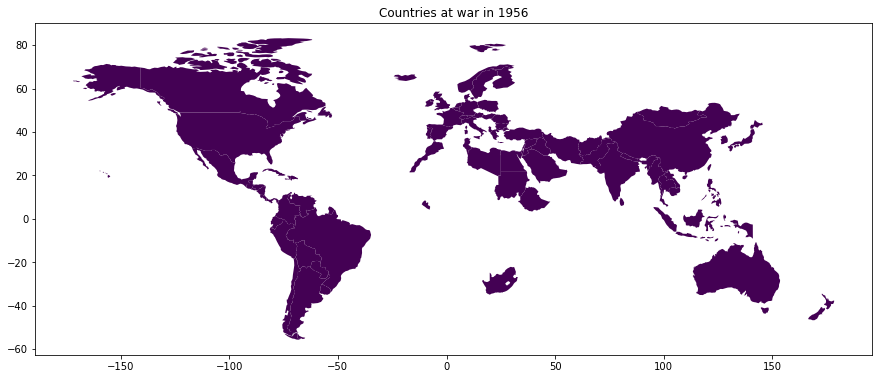

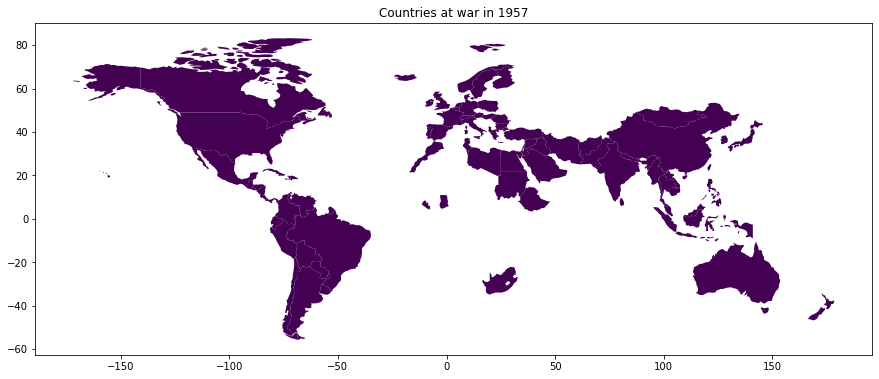

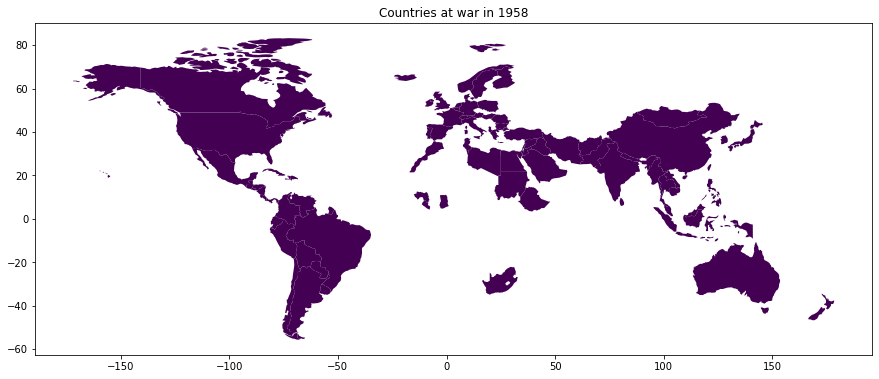

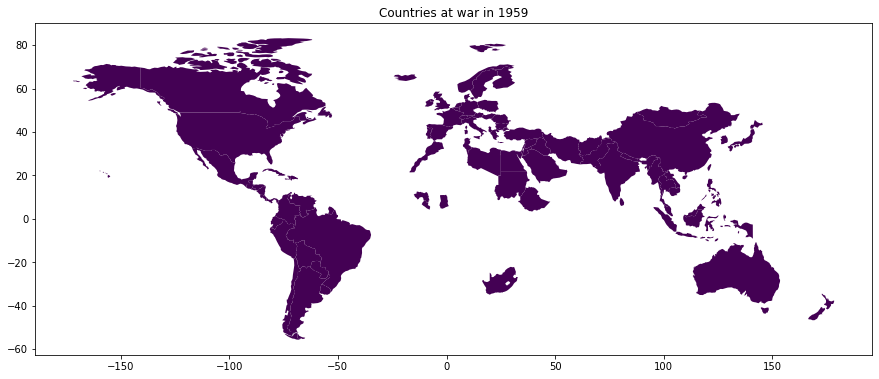

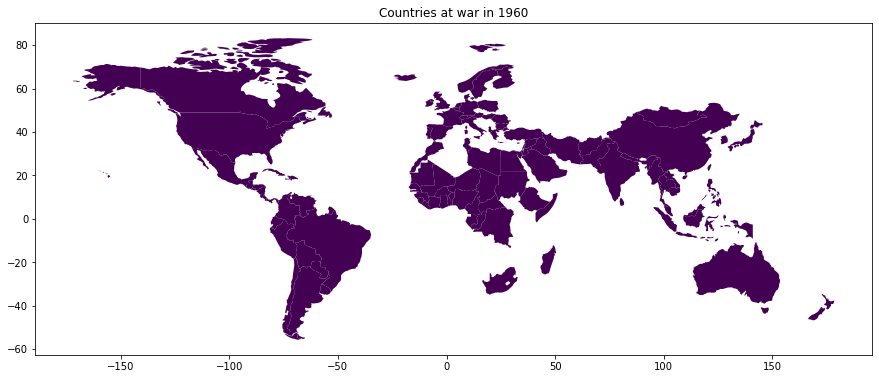

In [248]:
for year in war_map.year.unique().astype(int):
    print(f"Year: {year}")
    if year < 1961:
        continue
    
    war_map[war_map.year == year].plot(column="war", figsize=(15, 10)).set_title(f"Countries at war in {year}")
    plt.savefig(f"img/war_map_{year}")